# Anlysis of Turbine 3

Info:\
"The engine is operating normally at the start of each time series, and develops a fault at some point during the series. In the training set, the fault grows in magnitude until system failure. In the test set, the time series ends some time prior to system failure. The objective of the competition is to predict the number of remaining operational cycles before failure in the test set, i.e., the number of operational cycles after the last cycle that the engine will continue to operate. Also provided a vector of true Remaining Useful Life (RUL) values for the test data."\

Ideas:

* Create new variables
  * Expecially SM 10 (only starts before breakdown)
  * sm 6 (stops going down before breakdown)
  * sm 8, 12, and 13, Vairance gets lower before breakdown (id = 17)
* Search for other ideas
* Special threshold for extreme values. As we can see in the boxplots, some values only occur in the train-data -> they must occur shortly before breakdown
* Add rolling statistics for 30/60/90 days
* get slope of 30/60/90 days -> how much time do I still have?
* create a difference feature from start observation to the one of the cycle now




## Get data and libraries

In [ ]:
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 100)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from math import sqrt

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
train_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PSDA/Uebung2/data/train_FD003.txt', delim_whitespace=True, header=None)
test_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PSDA/Uebung2/data/test_FD003.txt', delim_whitespace=True, header=None)
rul_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PSDA/Uebung2/data/RUL_FD003.txt', delim_whitespace=True, header=None)

In [ ]:
# Eingabedateien haben keine Spaltennamen, hier die Namen der Spalte wird definiert
# Es enthält 26 Spalten: Motornummer, Zeitschritt, Drei betriebsbereite Sensoreinstellungen und 21 Sensormessungen.

# Motornummer, Zeitschritt
index_columns_names =  ["UnitNumber","Cycle"]
# 3 betriebsbereite Sensoreinstellungen
operational_settings_columns_names = ["Operation Setting "+str(i) for i in range(1,4)]
# 21 Sensormessungen
sensor_measure_columns_names =["Sensor Measure"+str(i) for i in range(1,22)]

input_file_column_names = index_columns_names + operational_settings_columns_names + sensor_measure_columns_names

train_data.columns = input_file_column_names
test_data.columns = input_file_column_names

## First Analysis

In [ ]:
print("Training Data:")
display(train_data.head())
print("\nTest Data:")
display(test_data.head())
print("\nRUL Data:")
display(rul_data.head())


Training Data:


UnitNumber  Cycle  Operation Setting 1  Operation Setting 2  Operation Setting 3  \
0           1      1              -0.0005               0.0004                100.0   
1           1      2               0.0008              -0.0003                100.0   
2           1      3              -0.0014              -0.0002                100.0   
3           1      4              -0.0020               0.0001                100.0   
4           1      5               0.0016               0.0000                100.0   

   Sensor Measure1  Sensor Measure2  Sensor Measure3  Sensor Measure4  Sensor Measure5  \
0           518.67           642.36          1583.23          1396.84            14.62   
1           518.67           642.50          1584.69          1396.89            14.62   
2           518.67           642.18          1582.35          1405.61            14.62   
3           518.67           642.92          1585.61          1392.27            14.62   
4           518.67           641.68          1588.63          1397.65            14.62   

   Sensor Measure6  Sensor Measure7  Sensor Measure8  Sensor Measure9  Sensor Measure10  \
0            21.61           553.97          2387.96          9062.17               1.3   
1            21.61           554.55          2388.00          9061.78               1.3   
2            21.61           554.43          2388.03          9070.23               1.3   
3            21.61           555.21          2388.00          9064.57               1.3   
4            21.61           554.74          2388.04          9076.14               1.3   

   Sensor Measure11  Sensor Measure12  Sensor Measure13  Sensor Measure14  Sensor Measure15  \
0             47.30            522.31           2388.01           8145.32            8.4246   
1             47.23            522.42           2388.03           8152.85            8.4403   
2             47.22            522.03           2388.00           8150.17            8.3901   
3             47.24            522.49           2388.08           8146.56            8.3878   
4             47.15            522.58           2388.03           8147.80            8.3869   

   Sensor Measure16  Sensor Measure17  Sensor Measure18  Sensor Measure19  Sensor Measure20  \
0              0.03               391              2388             100.0             39.11   
1              0.03               392              2388             100.0             38.99   
2              0.03               391              2388             100.0             38.85   
3              0.03               392              2388             100.0             38.96   
4              0.03               392              2388             100.0             39.14   

   Sensor Measure21  
0           23.3537  
1           23.4491  
2           23.3669  
3           23.2951  
4           23.4583


Test Data:


UnitNumber  Cycle  Operation Setting 1  Operation Setting 2  Operation Setting 3  \
0           1      1              -0.0017              -0.0004                100.0   
1           1      2               0.0006              -0.0002                100.0   
2           1      3               0.0014              -0.0003                100.0   
3           1      4               0.0027               0.0001                100.0   
4           1      5              -0.0001               0.0001                100.0   

   Sensor Measure1  Sensor Measure2  Sensor Measure3  Sensor Measure4  Sensor Measure5  \
0           518.67           641.94          1581.93          1396.93            14.62   
1           518.67           642.02          1584.86          1398.90            14.62   
2           518.67           641.68          1581.78          1391.92            14.62   
3           518.67           642.20          1584.53          1395.34            14.62   
4           518.67           642.46          1589.03          1395.86            14.62   

   Sensor Measure6  Sensor Measure7  Sensor Measure8  Sensor Measure9  Sensor Measure10  \
0            21.58           554.56          2387.93          9048.65               1.3   
1            21.58           554.10          2387.94          9046.53               1.3   
2            21.58           554.41          2387.97          9054.92               1.3   
3            21.59           554.58          2387.94          9055.04               1.3   
4            21.58           554.16          2388.01          9048.59               1.3   

   Sensor Measure11  Sensor Measure12  Sensor Measure13  Sensor Measure14  Sensor Measure15  \
0             47.09            521.89           2387.94           8133.48            8.3760   
1             47.08            521.85           2388.01           8137.44            8.4062   
2             47.15            522.10           2387.94           8138.25            8.3553   
3             47.26            522.45           2387.96           8137.07            8.3709   
4             46.94            521.91           2387.97           8134.20            8.4146   

   Sensor Measure16  Sensor Measure17  Sensor Measure18  Sensor Measure19  Sensor Measure20  \
0              0.03               391              2388             100.0             39.07   
1              0.03               391              2388             100.0             39.04   
2              0.03               391              2388             100.0             39.10   
3              0.03               392              2388             100.0             38.97   
4              0.03               391              2388             100.0             39.09   

   Sensor Measure21  
0           23.4468  
1           23.4807  
2           23.4244  
3           23.4782  
4           23.3950


RUL Data:


0
0   44
1   51
2   27
3  120
4  101

In [ ]:
print("Shape of Training Data:")
print(train_data.shape)
print("\nShape of Test Data:")
print(test_data.shape)
print("\nShape of RUL Data:")
print(rul_data.shape)

Shape of Training Data:
(24720, 26)

Shape of Test Data:
(16596, 26)

Shape of RUL Data:
(100, 1)


In [ ]:
#Get number of units
unique_units_train = train_data['UnitNumber'].nunique()
unique_units_test = test_data['UnitNumber'].nunique()

# Display the results
print("Unique unit numbers in Training Data:", unique_units_train)
print("Unique unit numbers in Test Data:", unique_units_test)

#Both have 100 Units with several Cycles per Unit. The RUL is the RUL for each Unit of the train set.

Unique unit numbers in Training Data: 100
Unique unit numbers in Test Data: 100


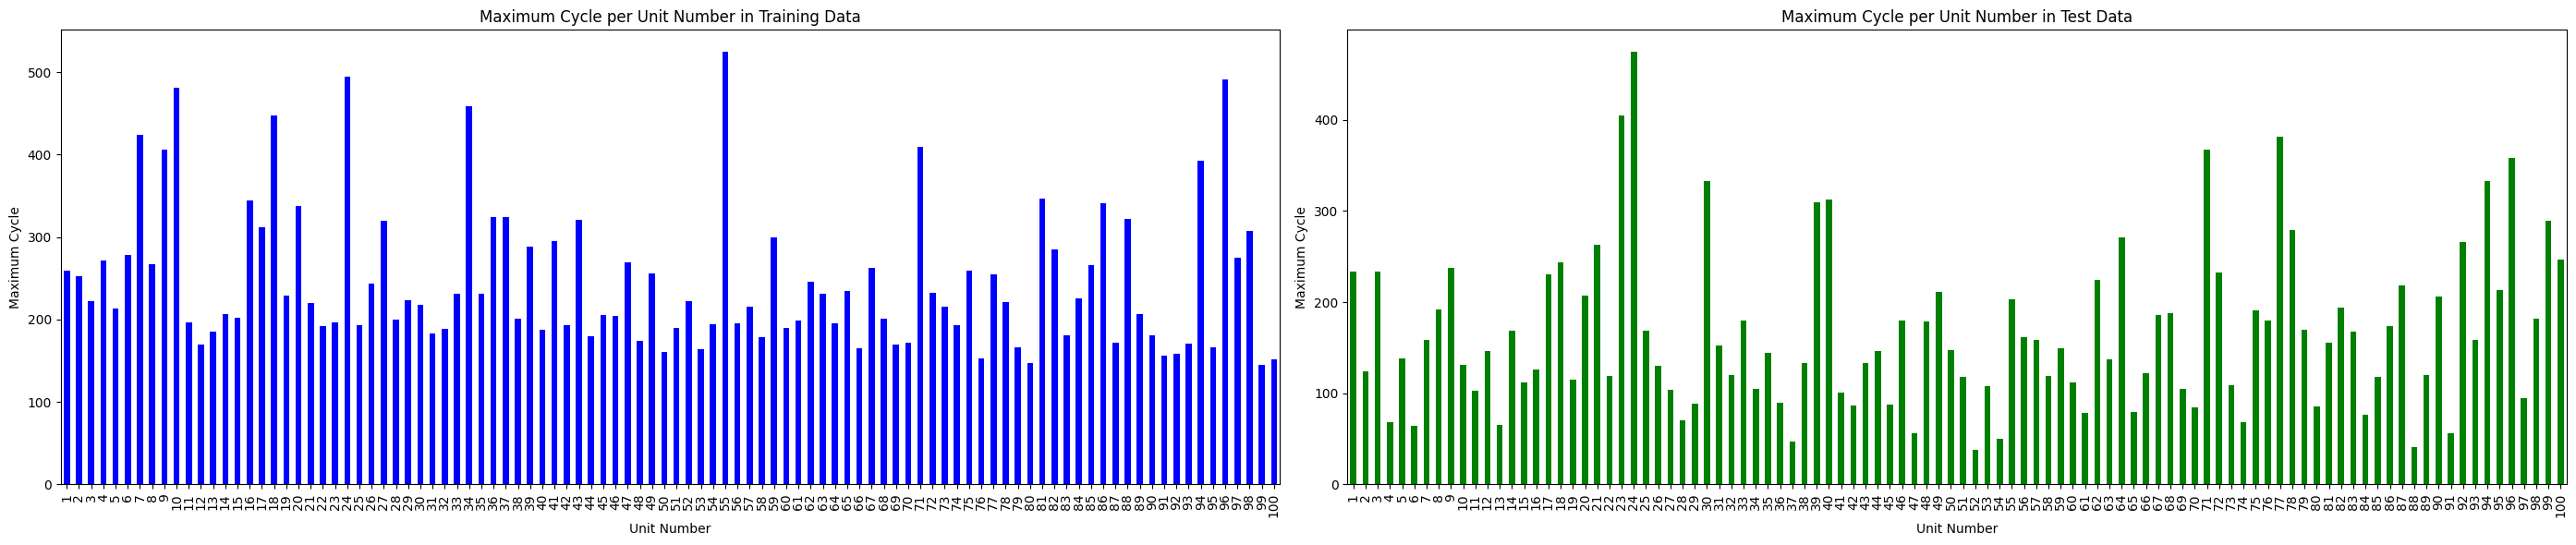


Average Max Cycle for Training Data  247.2

Average Max Cycle for Test Data  165.96


In [ ]:
# Group by 'UnitNumber' and find the maximum 'Cycle' for each unit in Training and Test Data
max_cycle_train = train_data.groupby('UnitNumber')['Cycle'].max()
max_cycle_test = test_data.groupby('UnitNumber')['Cycle'].max()

# Create the plot
plt.figure(figsize=(28, 6))

# Plot Training Data
plt.subplot(1, 2, 1)
max_cycle_train.plot(kind='bar', color='blue')
plt.title('Maximum Cycle per Unit Number in Training Data')
plt.xlabel('Unit Number')
plt.ylabel('Maximum Cycle')

# Plot Test Data
plt.subplot(1, 2, 2)
max_cycle_test.plot(kind='bar', color='green')
plt.title('Maximum Cycle per Unit Number in Test Data')
plt.xlabel('Unit Number')
plt.ylabel('Maximum Cycle')

plt.tight_layout()
plt.show()

print("\nAverage Max Cycle for Training Data ", np.mean(max_cycle_train) )
print("\nAverage Max Cycle for Test Data ", np.mean(max_cycle_test) )

### Closer Look on the Trainset

In [ ]:
display(train_data.describe())

UnitNumber         Cycle  Operation Setting 1  Operation Setting 2  Operation Setting 3  \
count  24720.000000  24720.000000         24720.000000         24720.000000              24720.0   
mean      48.631877    139.077063            -0.000024             0.000005                100.0   
std       29.348985     98.846675             0.002194             0.000294                  0.0   
min        1.000000      1.000000            -0.008600            -0.000600                100.0   
25%       23.000000     62.000000            -0.001500            -0.000200                100.0   
50%       47.000000    124.000000            -0.000000            -0.000000                100.0   
75%       74.000000    191.000000             0.001500             0.000300                100.0   
max      100.000000    525.000000             0.008600             0.000700                100.0   

       Sensor Measure1  Sensor Measure2  Sensor Measure3  Sensor Measure4  Sensor Measure5  \
count         24720.00     24720.000000     24720.000000     24720.000000     2.472000e+04   
mean            518.67       642.457858      1588.079175      1404.471212     1.462000e+01   
std               0.00         0.523031         6.810418         9.773178     3.552786e-15   
min             518.67       640.840000      1564.300000      1377.060000     1.462000e+01   
25%             518.67       642.080000      1583.280000      1397.187500     1.462000e+01   
50%             518.67       642.400000      1587.520000      1402.910000     1.462000e+01   
75%             518.67       642.790000      1592.412500      1410.600000     1.462000e+01   
max             518.67       645.110000      1615.390000      1441.160000     1.462000e+01   

       Sensor Measure6  Sensor Measure7  Sensor Measure8  Sensor Measure9  Sensor Measure10  \
count     24720.000000     24720.000000     24720.000000     24720.000000      24720.000000   
mean         21.595841       555.143808      2388.071555      9064.110809          1.301232   
std           0.018116         3.437343         0.158285        19.980294          0.003485   
min          21.450000       549.610000      2386.900000      9017.980000          1.290000   
25%          21.580000       553.110000      2388.000000      9051.920000          1.300000   
50%          21.600000       554.050000      2388.070000      9060.010000          1.300000   
75%          21.610000       556.040000      2388.140000      9070.092500          1.300000   
max          21.610000       570.490000      2388.600000      9234.350000          1.320000   

       Sensor Measure11  Sensor Measure12  Sensor Measure13  Sensor Measure14  Sensor Measure15  \
count      24720.000000      24720.000000      24720.000000      24720.000000      24720.000000   
mean          47.415707        523.050873       2388.071643       8144.202916          8.396176   
std            0.300074          3.255314          0.158121         16.504118          0.060512   
min           46.690000        517.770000       2386.930000       8099.680000          8.156300   
25%           47.190000        521.150000       2388.010000       8134.510000          8.360600   
50%           47.360000        521.980000       2388.070000       8141.200000          8.398300   
75%           47.600000        523.840000       2388.140000       8149.230000          8.437000   
max           48.440000        537.400000       2388.610000       8290.550000          8.570500   

       Sensor Measure16  Sensor Measure17  Sensor Measure18  Sensor Measure19  Sensor Measure20  \
count      2.472000e+04      24720.000000           24720.0           24720.0      24720.000000   
mean       3.000000e-02        392.566545            2388.0             100.0         38.988552   
std        1.734759e-17          1.761459               0.0               0.0          0.248865   
min        3.000000e-02        388.000000            2388.0             100.0         38.170000   
25%        3.00000

In [ ]:
print("\nData types and null counts:")
summary = pd.DataFrame({
    'Data Type': train_data.dtypes,
    'Null Count': train_data.isnull().sum()
})
print(summary)
print()
rows_with_missing_values = train_data[train_data.isnull().any(axis=1)]

print("Rows with missing values:")
print(rows_with_missing_values)


Data types and null counts:
                    Data Type  Null Count
UnitNumber              int64           0
Cycle                   int64           0
Operation Setting 1   float64           0
Operation Setting 2   float64           0
Operation Setting 3   float64           0
Sensor Measure1       float64           0
Sensor Measure2       float64           0
Sensor Measure3       float64           0
Sensor Measure4       float64           0
Sensor Measure5       float64           0
Sensor Measure6       float64           0
Sensor Measure7       float64           0
Sensor Measure8       float64           0
Sensor Measure9       float64           0
Sensor Measure10      float64           0
Sensor Measure11      float64           0
Sensor Measure12      float64           0
Sensor Measure13      float64           0
Sensor Measure14      float64           0
Sensor Measure15      float64           0
Sensor Measure16      float64           0
Sensor Measure17        int64           0
Senso

### Remane Columns

In [ ]:
# Dictionary to map old column names to new column names
rename_dict = {}
for col in train_data.columns:
    if col == "UnitNumber":
        rename_dict[col] = "unitnr"
    elif col == "Cycle":
        rename_dict[col] = "cycle"
    elif "Operation Setting" in col:
        number = col.split()[-1]  # Extract the number part from the column name
        rename_dict[col] = f"os{number}"
    elif "Sensor Measure" in col:
        number = col.split("Measure")[-1]
        rename_dict[col] = f"sm{number}"

# Rename the columns using the dictionary
train_data.rename(columns=rename_dict, inplace=True)
test_data.rename(columns=rename_dict, inplace=True)

# Display the new DataFrame columns to verify changes
print(train_data.columns)

Index(['unitnr', 'cycle', 'os1', 'os2', 'os3', 'sm1', 'sm2', 'sm3', 'sm4', 'sm5', 'sm6', 'sm7',
       'sm8', 'sm9', 'sm10', 'sm11', 'sm12', 'sm13', 'sm14', 'sm15', 'sm16', 'sm17', 'sm18',
       'sm19', 'sm20', 'sm21'],
      dtype='object')


### First Time-Series Analysis

In [ ]:
def print_time_series(dataframe = train_data, id=2):
    # Filter the DataFrame for the specified motor ID
    Dataframe_id = dataframe[dataframe["unitnr"] == id]

    # Generate a list of column names that include sensor measurements or principal components
    sensor_measure_columns_names = [
        col for col in Dataframe_id.columns
        if 'sm' in col or 'PC' in col  # Check for 'sm' and 'PC' in column names
    ]

    # Determine the number of columns to be plotted
    numberOfcolumns = len(sensor_measure_columns_names)

    # Set up the figure with an appropriate size based on the number of columns
    plt.figure(figsize=(15, 2.5 * numberOfcolumns))

    # Plot each column in a separate subplot
    for i, col_name in enumerate(sensor_measure_columns_names):
        ax = plt.subplot(numberOfcolumns, 1, i + 1)
        ax.plot(Dataframe_id.index.values, Dataframe_id[col_name].values)  # Use column names directly
        ax.title.set_text(col_name)
        plt.tight_layout()

    # Print a description and show the plot
    print(f"Zeitliche Verlauf von Turbofan mit id {id}. X Axis is the Cycle Number, Y Axis is the Sensor Value")
    plt.show()


Zeitliche Verlauf von Turbofan mit id 57. X Axis is the Cycle Number, Y Axis is the Sensor Value


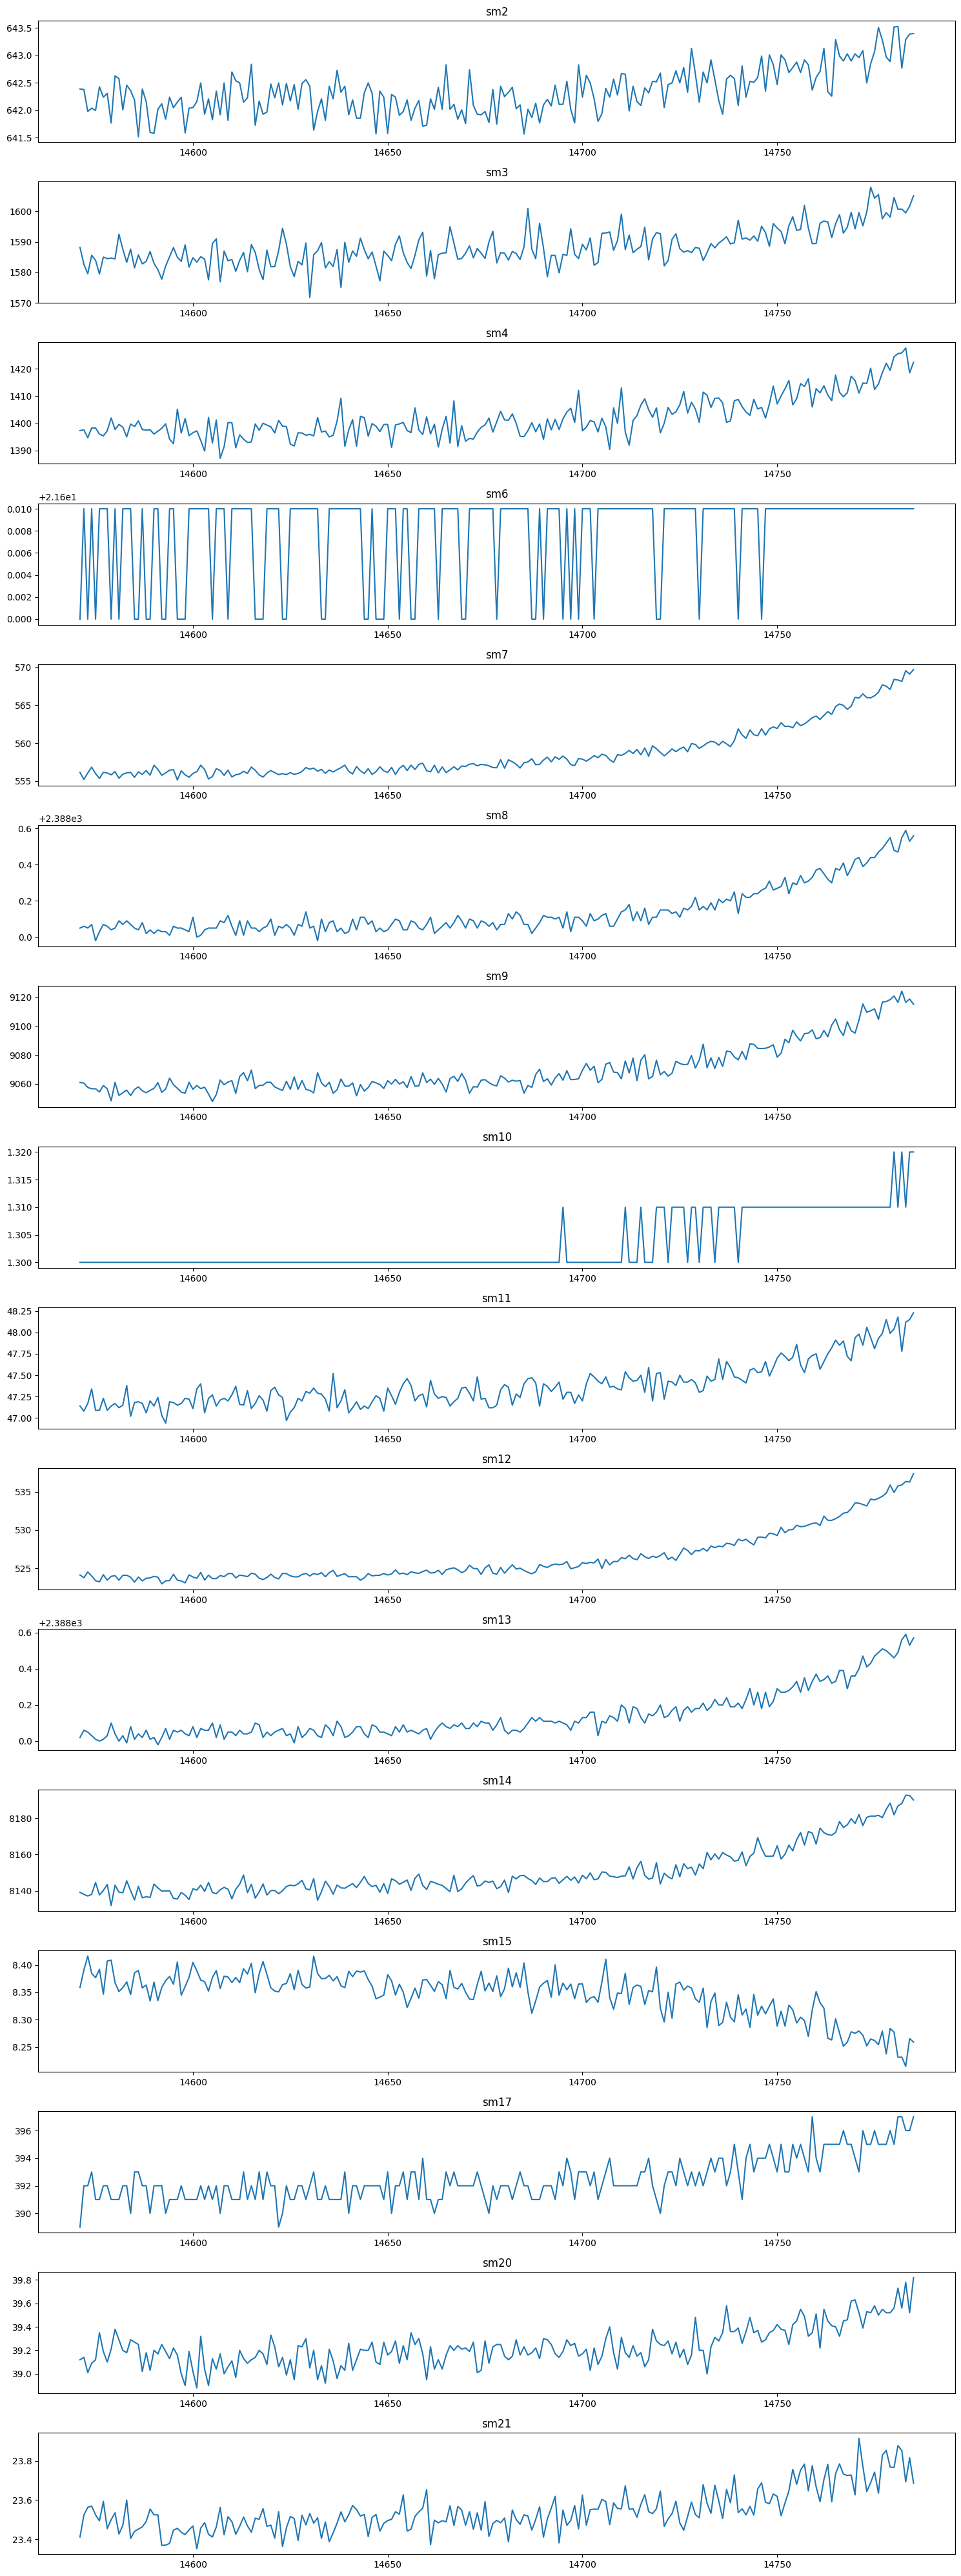

In [ ]:
print_time_series(id=57)

### Remove with std = 0, but save their values to compare with other teststes

In [ ]:
# Calculate the standard deviation for each column in the DataFrame
std_devs = train_data.std()

# Identify columns where the standard deviation is 0
zero_std_cols = std_devs[std_devs == 0].index.tolist()

# Loop through each column with std of 0, print the column name and its constant value
for col in zero_std_cols:
    print(f"Column: {col}, Constant Value: {train_data[col].iloc[0]}")

# Remove the columns with a standard deviation of 0 from the DataFrame
train_data.drop(columns=zero_std_cols, inplace=True)

# Optionally, print the DataFrame to verify the columns are removed
display(train_data.describe())

Column: os3, Constant Value: 100.0
Column: sm1, Constant Value: 518.67
Column: sm18, Constant Value: 2388
Column: sm19, Constant Value: 100.0


unitnr         cycle           os1           os2           sm2           sm3  \
count  24720.000000  24720.000000  24720.000000  24720.000000  24720.000000  24720.000000   
mean      48.631877    139.077063     -0.000024      0.000005    642.457858   1588.079175   
std       29.348985     98.846675      0.002194      0.000294      0.523031      6.810418   
min        1.000000      1.000000     -0.008600     -0.000600    640.840000   1564.300000   
25%       23.000000     62.000000     -0.001500     -0.000200    642.080000   1583.280000   
50%       47.000000    124.000000     -0.000000     -0.000000    642.400000   1587.520000   
75%       74.000000    191.000000      0.001500      0.000300    642.790000   1592.412500   
max      100.000000    525.000000      0.008600      0.000700    645.110000   1615.390000   

                sm4           sm5           sm6           sm7           sm8           sm9  \
count  24720.000000  2.472000e+04  24720.000000  24720.000000  24720.000000  24720.000000   
mean    1404.471212  1.462000e+01     21.595841    555.143808   2388.071555   9064.110809   
std        9.773178  3.552786e-15      0.018116      3.437343      0.158285     19.980294   
min     1377.060000  1.462000e+01     21.450000    549.610000   2386.900000   9017.980000   
25%     1397.187500  1.462000e+01     21.580000    553.110000   2388.000000   9051.920000   
50%     1402.910000  1.462000e+01     21.600000    554.050000   2388.070000   9060.010000   
75%     1410.600000  1.462000e+01     21.610000    556.040000   2388.140000   9070.092500   
max     1441.160000  1.462000e+01     21.610000    570.490000   2388.600000   9234.350000   

               sm10          sm11          sm12          sm13          sm14          sm15  \
count  24720.000000  24720.000000  24720.000000  24720.000000  24720.000000  24720.000000   
mean       1.301232     47.415707    523.050873   2388.071643   8144.202916      8.396176   
std        0.003485      0.300074      3.255314      0.158121     16.504118      0.060512   
min        1.290000     46.690000    517.770000   2386.930000   8099.680000      8.156300   
25%        1.300000     47.190000    521.150000   2388.010000   8134.510000      8.360600   
50%        1.300000     47.360000    521.980000   2388.070000   8141.200000      8.398300   
75%        1.300000     47.600000    523.840000   2388.140000   8149.230000      8.437000   
max        1.320000     48.440000    537.400000   2388.610000   8290.550000      8.570500   

               sm16          sm17          sm20          sm21  
count  2.472000e+04  24720.000000  24720.000000  24720.000000  
mean   3.000000e-02    392.566545     38.988552     23.393024  
std    1.734759e-17      1.761459      0.248865      0.149234  
min    3.000000e-02    388.000000     38.170000     22.872600  
25%    3.000000e-02    391.000000     38.830000     23.296200  
50%    3.000000e-02    392.000000     38.990000     23.391600  
75%    3.000000e-02    394.000000     39.140000     23.483300  
max    3.000000e-02    399.000000     39.850000     23.950500

In [ ]:
# Also remove 5 and 16 as they only have the same value, but due to some calculation problems they won't get dropped

columns_to_remove = ["sm5", "sm16"]
all_columns_to_drop = zero_std_cols + columns_to_remove
train_data.drop(columns=columns_to_remove, inplace = True)
display(train_data.describe())

unitnr         cycle           os1           os2           sm2           sm3  \
count  24720.000000  24720.000000  24720.000000  24720.000000  24720.000000  24720.000000   
mean      48.631877    139.077063     -0.000024      0.000005    642.457858   1588.079175   
std       29.348985     98.846675      0.002194      0.000294      0.523031      6.810418   
min        1.000000      1.000000     -0.008600     -0.000600    640.840000   1564.300000   
25%       23.000000     62.000000     -0.001500     -0.000200    642.080000   1583.280000   
50%       47.000000    124.000000     -0.000000     -0.000000    642.400000   1587.520000   
75%       74.000000    191.000000      0.001500      0.000300    642.790000   1592.412500   
max      100.000000    525.000000      0.008600      0.000700    645.110000   1615.390000   

                sm4           sm6           sm7           sm8           sm9          sm10  \
count  24720.000000  24720.000000  24720.000000  24720.000000  24720.000000  24720.000000   
mean    1404.471212     21.595841    555.143808   2388.071555   9064.110809      1.301232   
std        9.773178      0.018116      3.437343      0.158285     19.980294      0.003485   
min     1377.060000     21.450000    549.610000   2386.900000   9017.980000      1.290000   
25%     1397.187500     21.580000    553.110000   2388.000000   9051.920000      1.300000   
50%     1402.910000     21.600000    554.050000   2388.070000   9060.010000      1.300000   
75%     1410.600000     21.610000    556.040000   2388.140000   9070.092500      1.300000   
max     1441.160000     21.610000    570.490000   2388.600000   9234.350000      1.320000   

               sm11          sm12          sm13          sm14          sm15          sm17  \
count  24720.000000  24720.000000  24720.000000  24720.000000  24720.000000  24720.000000   
mean      47.415707    523.050873   2388.071643   8144.202916      8.396176    392.566545   
std        0.300074      3.255314      0.158121     16.504118      0.060512      1.761459   
min       46.690000    517.770000   2386.930000   8099.680000      8.156300    388.000000   
25%       47.190000    521.150000   2388.010000   8134.510000      8.360600    391.000000   
50%       47.360000    521.980000   2388.070000   8141.200000      8.398300    392.000000   
75%       47.600000    523.840000   2388.140000   8149.230000      8.437000    394.000000   
max       48.440000    537.400000   2388.610000   8290.550000      8.570500    399.000000   

               sm20          sm21  
count  24720.000000  24720.000000  
mean      38.988552     23.393024  
std        0.248865      0.149234  
min       38.170000     22.872600  
25%       38.830000     23.296200  
50%       38.990000     23.391600  
75%       39.140000     23.483300  
max       39.850000     23.950500

### Creating goal-variable RUL for Train-Set

In [ ]:
def add_remaining_useful_life(df):
    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="unitnr")
    max_cycle = grouped_by_unit["cycle"].max()

    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unitnr', right_index=True)

    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["cycle"]
    result_frame["RUL"] = remaining_useful_life

    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame

train_data = add_remaining_useful_life(train_data)
train_data.head()

unitnr  cycle     os1     os2     sm2      sm3      sm4    sm6     sm7      sm8      sm9  sm10  \
0       1      1 -0.0005  0.0004  642.36  1583.23  1396.84  21.61  553.97  2387.96  9062.17   1.3   
1       1      2  0.0008 -0.0003  642.50  1584.69  1396.89  21.61  554.55  2388.00  9061.78   1.3   
2       1      3 -0.0014 -0.0002  642.18  1582.35  1405.61  21.61  554.43  2388.03  9070.23   1.3   
3       1      4 -0.0020  0.0001  642.92  1585.61  1392.27  21.61  555.21  2388.00  9064.57   1.3   
4       1      5  0.0016  0.0000  641.68  1588.63  1397.65  21.61  554.74  2388.04  9076.14   1.3   

    sm11    sm12     sm13     sm14    sm15  sm17   sm20     sm21  RUL  
0  47.30  522.31  2388.01  8145.32  8.4246   391  39.11  23.3537  258  
1  47.23  522.42  2388.03  8152.85  8.4403   392  38.99  23.4491  257  
2  47.22  522.03  2388.00  8150.17  8.3901   391  38.85  23.3669  256  
3  47.24  522.49  2388.08  8146.56  8.3878   392  38.96  23.2951  255  
4  47.15  522.58  2388.03  8147.80  8.3869   392  39.14  23.4583  254

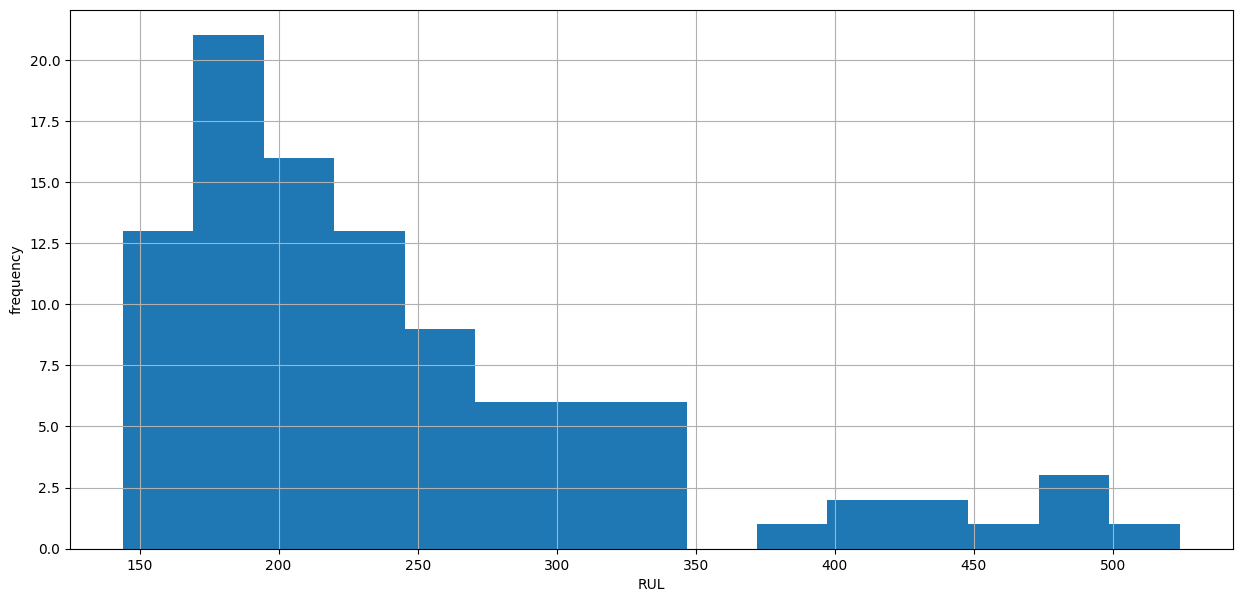

In [ ]:
df_max_rul = train_data[['unitnr', 'RUL']].groupby('unitnr').max().reset_index()
df_max_rul['RUL'].hist(bins=15, figsize=(15,7))
plt.xlabel('RUL')
plt.ylabel('frequency')
plt.show()

### Check Operational Settings

In [ ]:
def plot_operational_settings(data):
    # Unique list of unit numbers
    unit_numbers = data['unitnr'].unique()[:3]

    # Determine the number of unit numbers to set figure size dynamically
    plt.figure(figsize=(15, 5 * len(unit_numbers)))

    # Loop through each unit number and plot operational settings
    for i, unit in enumerate(unit_numbers, start=1):
        # Filter data for the specific unit
        unit_data = data[data['unitnr'] == unit]

        # Create subplot for each unit
        ax = plt.subplot(len(unit_numbers), 1, i)
        ax.plot(unit_data['cycle'], unit_data['os1'], label='OS1', marker='o', linestyle='-')
        ax.plot(unit_data['cycle'], unit_data['os2'], label='OS2', marker='x', linestyle='--')

        # Adding titles and labels
        ax.set_title(f'Operational Settings Over Cycles for Unit {unit}')
        ax.set_xlabel('Cycle')
        ax.set_ylabel('Operational Setting Value')
        ax.legend()

    plt.tight_layout()
    plt.show()


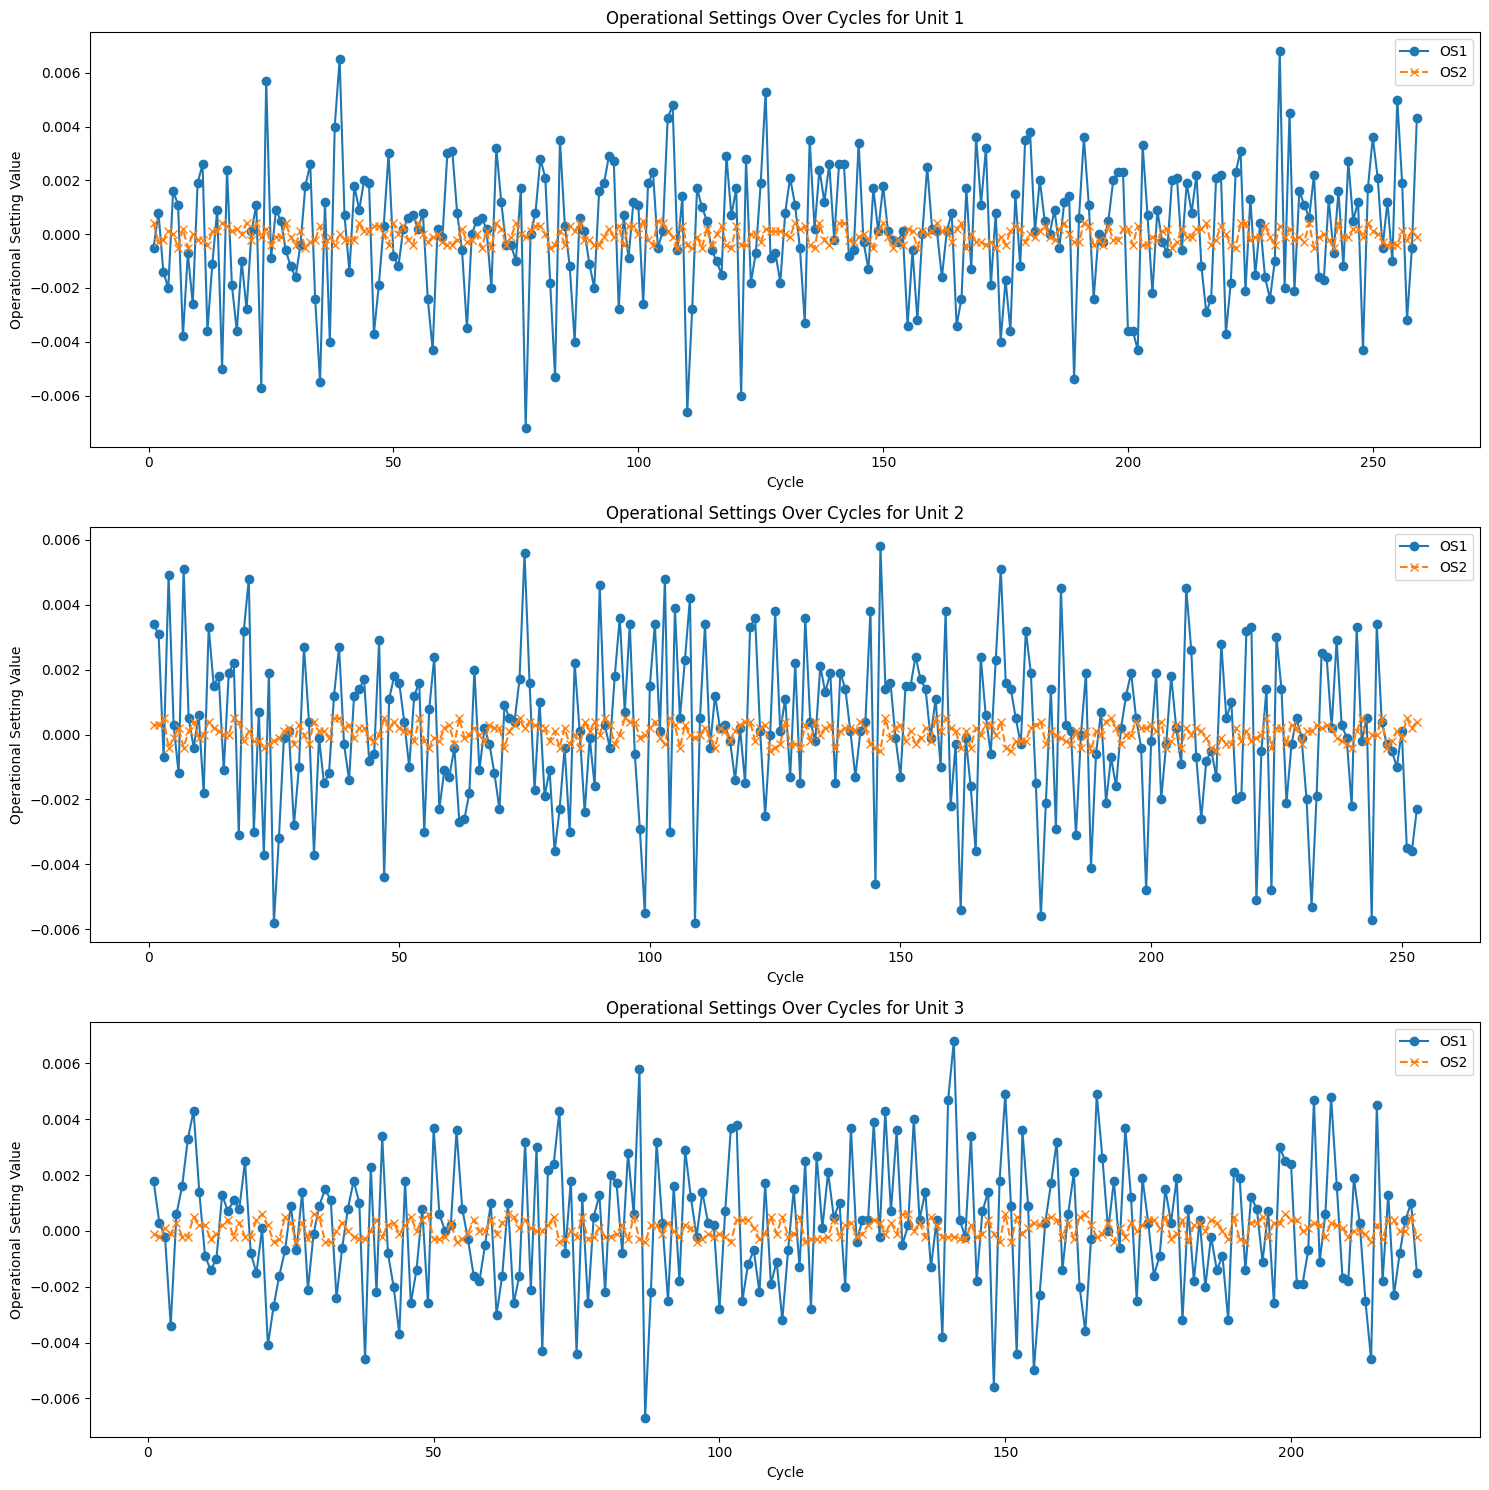

In [ ]:
plot_operational_settings(train_data)

## Check relationship between Max Cycles and Remaining Useful Lifetime


In [ ]:
max_cycle_test_df = max_cycle_test.to_frame(name='Max Cycle')

# Optionally, if you want to reset the index to make the original index a column
max_cycle_test_df.reset_index(inplace=True)
max_cycle_test_df.rename(columns={'index': 'Unit Number'}, inplace=True)
max_cycle_test_df['RUL'] = rul_data

# Display the new DataFrame
print(max_cycle_test_df)

    UnitNumber  Max Cycle  RUL
0            1        233   44
1            2        124   51
2            3        234   27
3            4         68  120
4            5        138  101
..         ...        ...  ...
95          96        358  113
96          97         95  123
97          98        182   17
98          99        289    8
99         100        247   28

[100 rows x 3 columns]


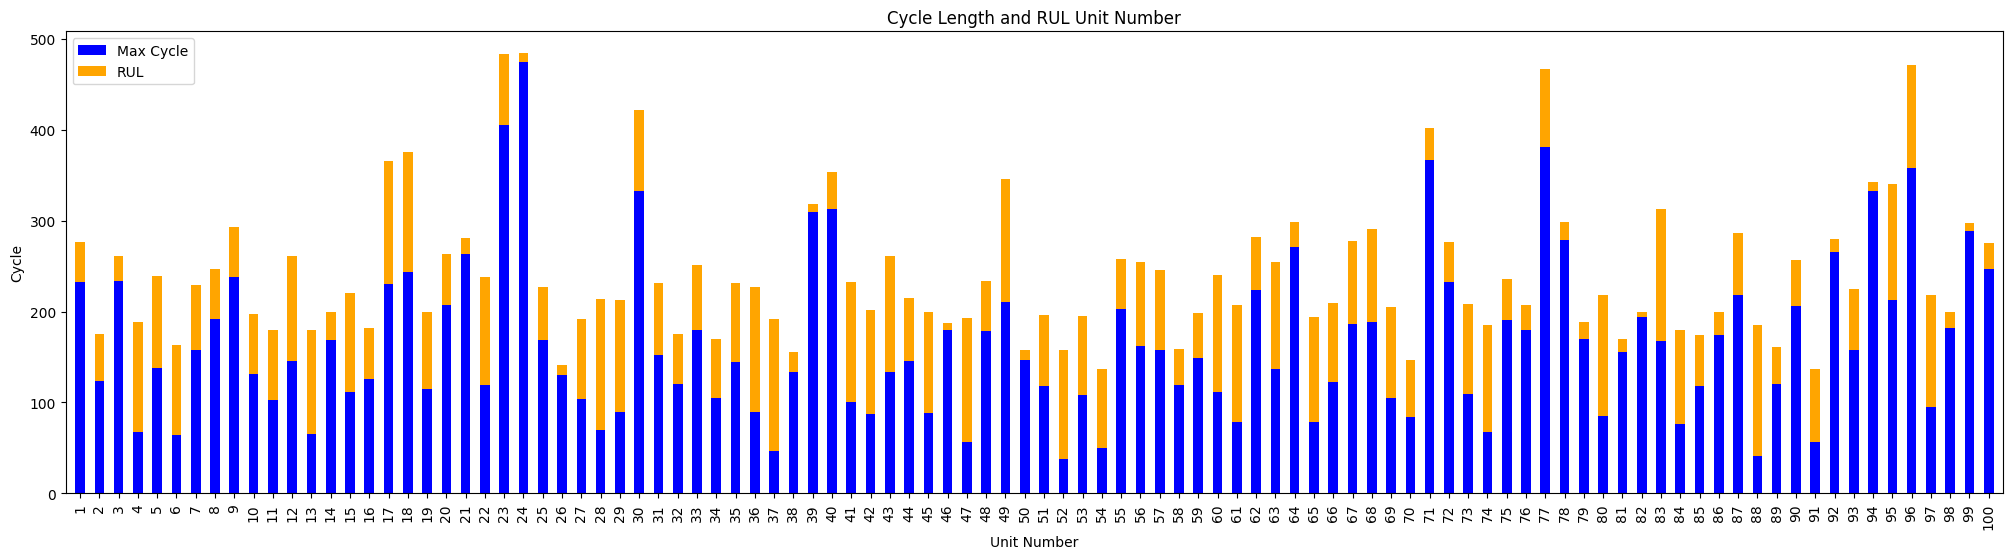

Correlation coefficient: -0.4842054127596086
P-value: 3.3232563781600715e-07
Negative and significant Correlation -> logical


In [ ]:
# Setting up the figure and axis
plt.figure(figsize=(25, 6))
ax = plt.gca()

# Data preparation
units = max_cycle_test_df['UnitNumber']  # Extracting Unit Numbers
max_cycles = max_cycle_test_df['Max Cycle']  # Extracting Max Cycle values
ruls = max_cycle_test_df['RUL']  # Extracting RUL values


index = np.arange(len(units))
bar_width = 0.5

# Creating the bar for Max Cycle
ax.bar(index, max_cycles, bar_width, label='Max Cycle', color='blue')

# Stacking the RUL bar on top of the Max Cycle bar
ax.bar(index, ruls, bar_width, bottom=max_cycles, label='RUL', color='orange')

# Adding title and labels
ax.set_xlabel('Unit Number')
ax.set_ylabel('Cycle')
ax.set_title('Cycle Length and RUL Unit Number')
ax.set_xticks(index)
ax.set_xticklabels(units)

# Rotate x-labels vertically
plt.xticks(rotation='vertical')

# Remove the margins on the x-axis
plt.margins(x=0.005)

# Adding legend
ax.legend()

# Show the plot
plt.show()

# Extract the two columns as numpy arrays
max_cycle_values = max_cycle_test_df['Max Cycle']
rul_values = max_cycle_test_df['RUL']

# Calculate Pearson's correlation
correlation, p_value = pearsonr(max_cycle_values, rul_values)

# Print the correlation and the p-value
print("Correlation coefficient:", correlation)
print("P-value:", p_value)
print("Negative and significant Correlation -> logical")

## Check Correlation

First for all data and then also for last round to see significant indicators for machine breakdown

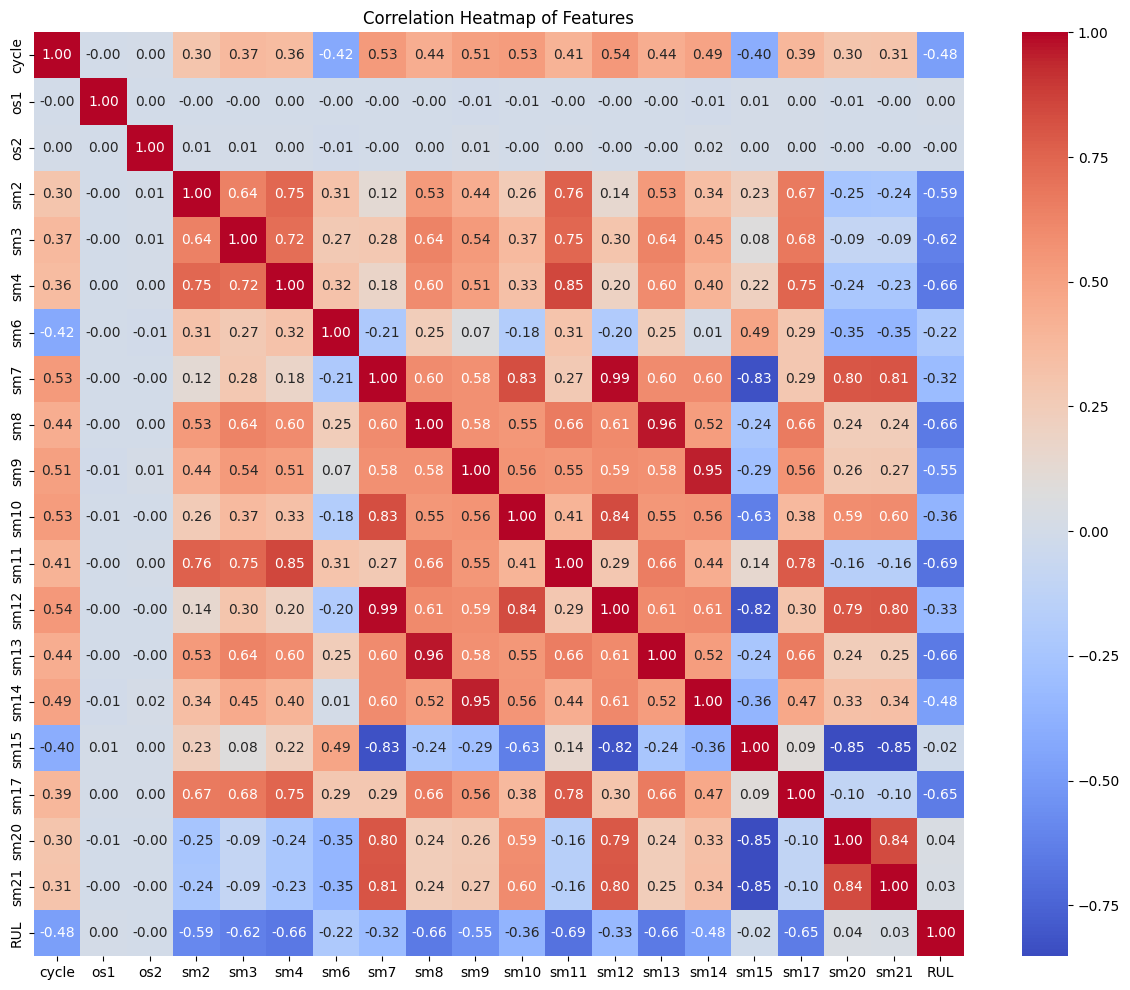

In [ ]:
# Compute the correlation matrix for all columns except 'unitnr'
corr_matrix = train_data.drop('unitnr', axis=1).corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(15, 12))  # Adjust the size of the figure as needed
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap of Features')
plt.show()

### Remove features with correlation of > 90% Correlation

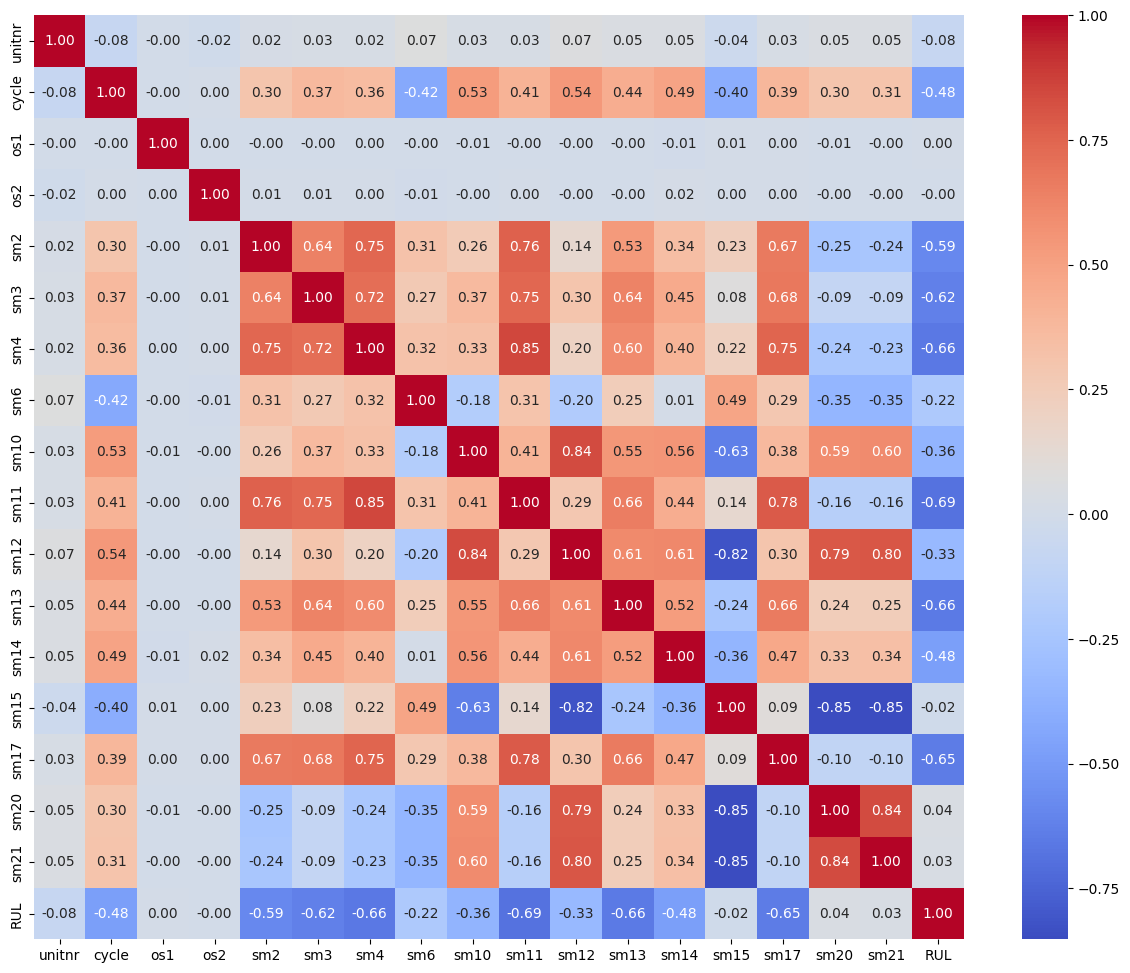

In [ ]:
# Identify pairs of features with correlation greater than 0.95
high_corr = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.95:  # absolute value of correlation coefficient
            colname = corr_matrix.columns[i]
            high_corr.add(colname)

# Decide which features to drop
# For simplicity, let's drop all identified features
train_data.drop(columns=list(high_corr), inplace=True)

corr_matrix = train_data.corr()

# Visualize the correlation matrix
plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

### PCA for two Correlation Clusters

Cluster 1: Sensor Measurements 10,12,15,20,21
Cluster 2: Sensor Measurements 2,3,4,11,17

Correlationts of over 70%

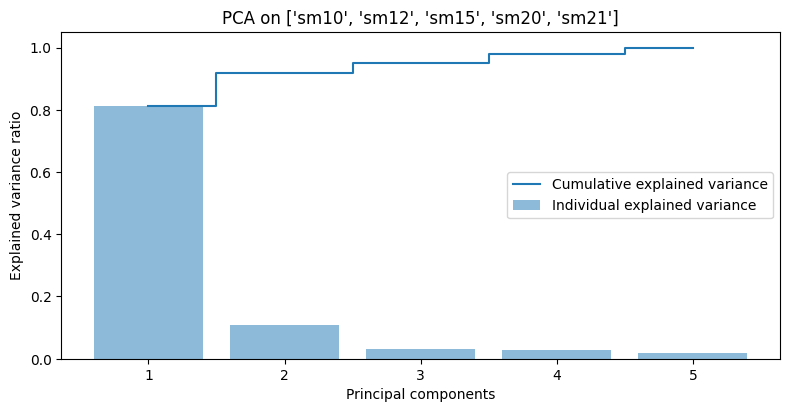

Cluster 1 Components Needed: 2


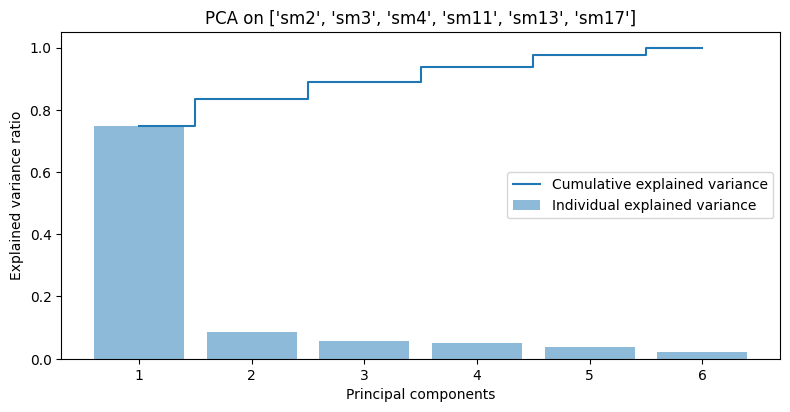

Cluster 2 Components Needed: 4


In [ ]:
# Define the clusters of features
cluster_1 = ['sm10', 'sm12', 'sm15', 'sm20', 'sm21']
cluster_2 = ['sm2', 'sm3', 'sm4', 'sm11','sm13', 'sm17']

# Function to perform PCA and plot explained variance
def perform_pca(features, threshold=0.9):
    # Filter the data to include only the specified features
    data_subset = train_data[features]

    # Standardize the data
    scaler = StandardScaler()
    data_std = scaler.fit_transform(data_subset)

    # Initialize PCA
    pca = PCA()

    # Fit PCA on the standardized data
    pca.fit(data_std)

    # Calculate cumulative sum of explained variances
    cum_var_exp = np.cumsum(pca.explained_variance_ratio_)

    # Determine the number of components to reach the threshold
    num_components = np.where(cum_var_exp >= threshold)[0][0] + 1

    # Plot the explained variances
    plt.figure(figsize=(8, 4))
    plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, alpha=0.5, align='center',
            label='Individual explained variance')
    plt.step(range(1, len(cum_var_exp) + 1), cum_var_exp, where='mid',
             label='Cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.title(f"PCA on {features}")
    plt.show()

    return num_components

# Perform PCA on each cluster
print("Cluster 1 Components Needed:", perform_pca(cluster_1))
print("Cluster 2 Components Needed:", perform_pca(cluster_2))

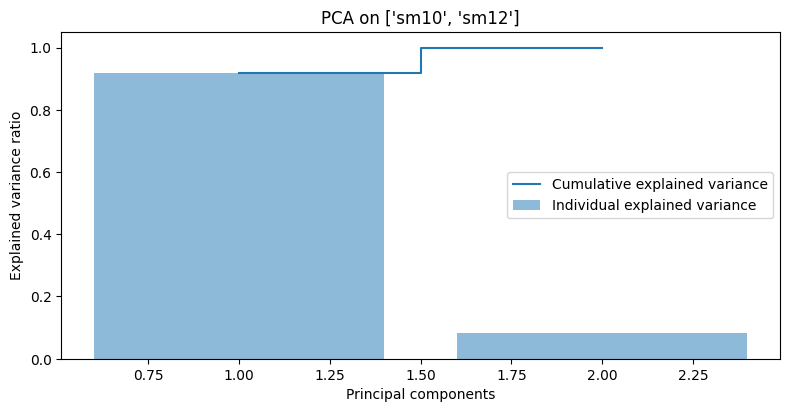

Cluster 1.1 Components Needed: 1


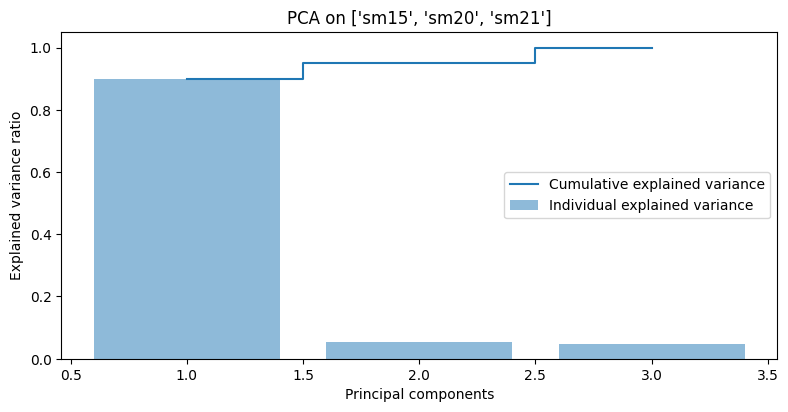

Cluster 1.2 Components Needed: 1


In [ ]:
#Split Cluster 1 further into cluster 1.1 (10,12) and cluster 1.2 (15, 20, 21)
cluster_11 = ['sm10', 'sm12']
cluster_12 = ['sm15', 'sm20', 'sm21']

print("Cluster 1.1 Components Needed:", perform_pca(cluster_11))
print("Cluster 1.2 Components Needed:", perform_pca(cluster_12, 0.89))

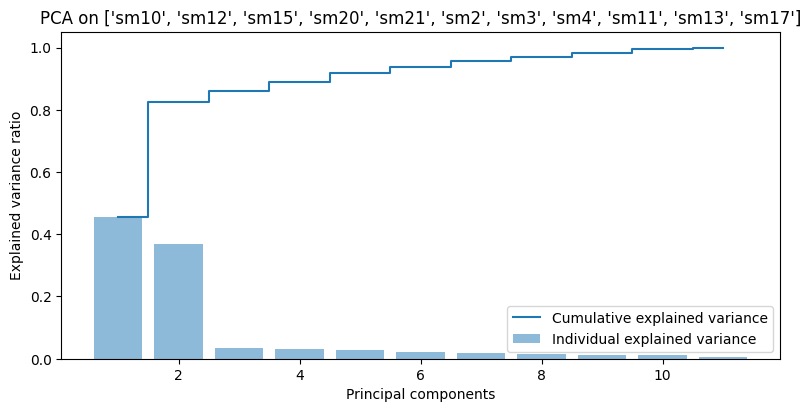

Both clusters together Components Needed: 7


In [ ]:
combined_cluster = cluster_1 + cluster_2
print("Both clusters together Components Needed:", perform_pca(combined_cluster, 0.95))

#### Perform PCA and remove features

In [ ]:


# Assuming 'train_data' is your DataFrame and it contains the relevant features for two clusters

# Define the clusters of features
clusters = {
    'cluster_1': ['sm10', 'sm12', 'sm15', 'sm20', 'sm21'],
    #'cluster_11': ['sm10', 'sm12'],
    #'cluster_12': ['sm15', 'sm20', 'sm21'],
    'cluster_2': ['sm2', 'sm3', 'sm4', 'sm11','sm13' ,'sm17']
}

# Initialize the StandardScaler
scaler = StandardScaler()

# Function to perform PCA and return a DataFrame of results and loadings
def perform_pca(features, cluster_name):
    # Filter and scale the data
    X = train_data[features]
    X_scaled = scaler.fit_transform(X)

    # Configure PCA to capture 90% of the variance
    pca = PCA(n_components=0.9)
    X_pca = pca.fit_transform(X_scaled)

    # Calculate number of components and explained variance
    num_components = pca.n_components_
    variance_ratio = pca.explained_variance_ratio_.sum()

    # Create DataFrame for PCA results
    df_pca = pd.DataFrame(X_pca, columns=[f'{cluster_name}_PC{i+1}' for i in range(num_components)])

    # Create DataFrame for Loadings
    loadings_df = pd.DataFrame(pca.components_, columns=features, index=[f'{cluster_name}_PC{i+1}' for i in range(num_components)])

    return df_pca, variance_ratio, loadings_df

# Apply PCA to each cluster
results = {}
for name, features in clusters.items():
    df_pca, variance_ratio, loadings_df = perform_pca(features, name)
    results[name] = {'PCA Results': df_pca, 'Explained Variance Ratio': variance_ratio, 'Loadings': loadings_df}

# Print results in a structured way
for cluster, result in results.items():
    print(f"\n{cluster} - Number of components: {result['PCA Results'].shape[1]}")
    print(f"{cluster} - Explained variance ratio: {result['Explained Variance Ratio']:.4f}")
    print(f"\n{cluster} - Principal Component Loadings:")
    display(result['Loadings'])





cluster_1 - Number of components: 2
cluster_1 - Explained variance ratio: 0.9197

cluster_1 - Principal Component Loadings:


sm10      sm12      sm15      sm20      sm21
cluster_1_PC1  0.399643  0.468516 -0.459948  0.451431  0.453250
cluster_1_PC2  0.780269  0.273539  0.272851 -0.357507 -0.337783


cluster_2 - Number of components: 4
cluster_2 - Explained variance ratio: 0.9383

cluster_2 - Principal Component Loadings:


sm2       sm3       sm4      sm11      sm13      sm17
cluster_2_PC1  0.396120  0.401453  0.426622  0.439026  0.368533  0.413953
cluster_2_PC2  0.497424 -0.127763  0.272226  0.150129 -0.795349 -0.083789
cluster_2_PC3 -0.215301  0.867812 -0.007446 -0.034798 -0.243775 -0.373972
cluster_2_PC4 -0.657020 -0.001568  0.216459  0.130601 -0.375431  0.602879

In [ ]:
# Create a copy of train_data without the cluster columns
all_cluster_columns = [col for cluster in clusters.values() for col in cluster]  # Flatten the list of cluster columns
train_data_reduced = train_data.drop(columns=all_cluster_columns)

# Combine the reduced train_data with PCA results from each cluster
for cluster, result in results.items():
    train_data_reduced = pd.concat([train_data_reduced, result['PCA Results']], axis=1)

# Make RUL last column
rul_column = train_data_reduced.pop('RUL')
train_data_reduced['RUL'] = rul_column

# Display the first few rows of the new DataFrame to verify the changes
display(train_data_reduced.head())

unitnr  cycle     os1     os2    sm6     sm14  cluster_1_PC1  cluster_1_PC2  cluster_2_PC1  \
0       1      1 -0.0005  0.0004  21.61  8145.32      -0.363083      -0.295356      -1.374211   
1       1      2  0.0008 -0.0003  21.61  8152.85      -0.394516      -0.258866      -1.000722   
2       1      3 -0.0014 -0.0002  21.61  8150.17      -0.572691      -0.130817      -1.319928   
3       1      4 -0.0020  0.0001  21.61  8146.56      -0.507536      -0.098039      -0.698903   
4       1      5  0.0016  0.0000  21.61  8147.80       0.334456      -0.722522      -1.473381   

   cluster_2_PC2  cluster_2_PC3  cluster_2_PC4  RUL  
0       0.112037      -0.130764      -0.485150  258  
1       0.035995      -0.237419      -0.395933  257  
2       0.211919      -0.150790      -0.075661  256  
3       0.042988      -0.367806      -1.140444  255  
4      -0.836645       0.610892       0.615260  254

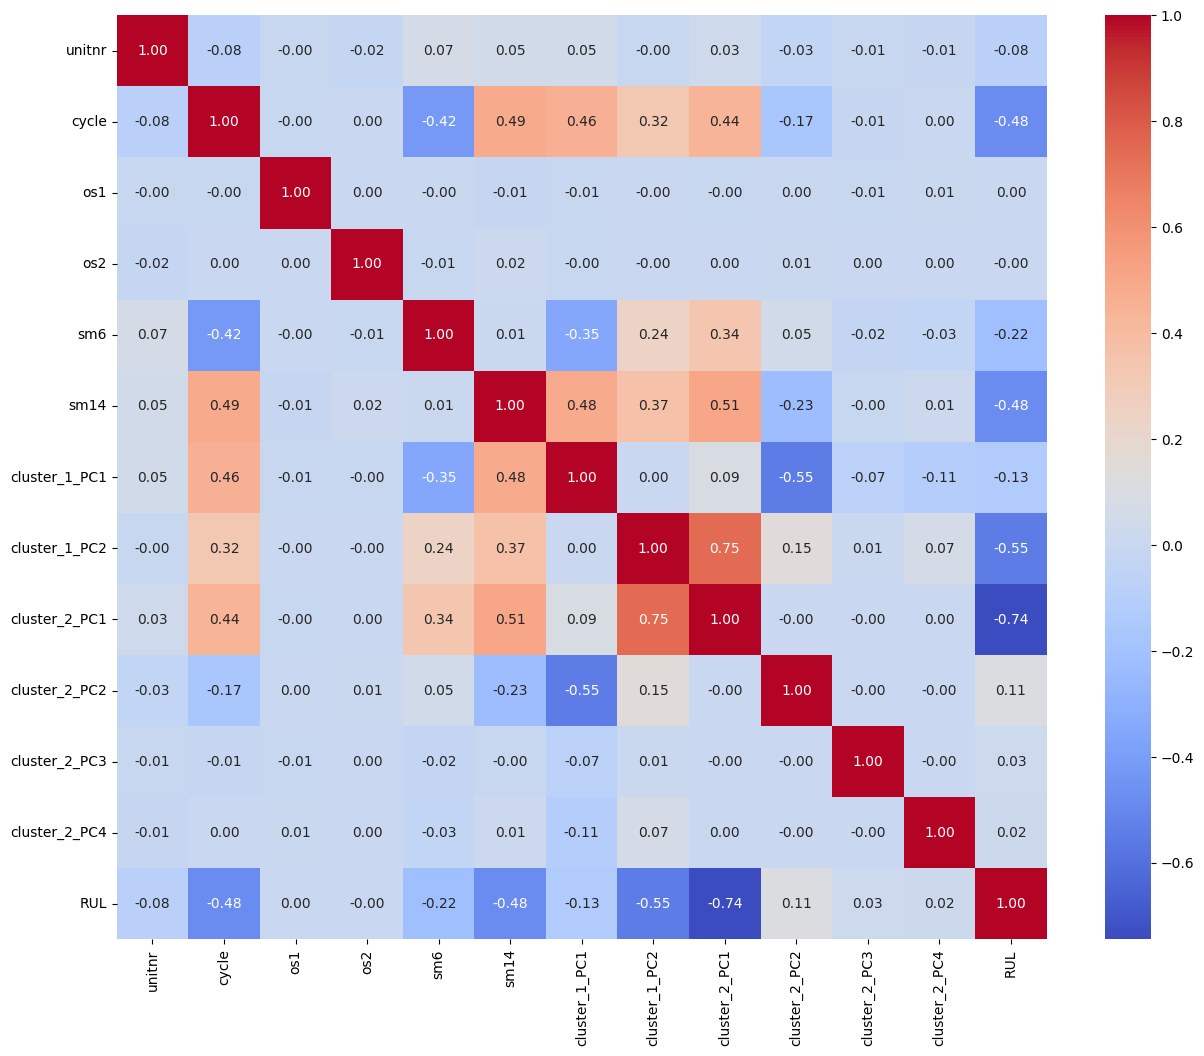

In [ ]:
columns_to_drop = cluster_1 + cluster_2
train_data_reduced_modified = train_data_reduced.drop(columns=[col for col in columns_to_drop if col in train_data_reduced.columns])

# Compute the correlation matrix for the modified DataFrame
corr_matrix = train_data_reduced_modified.corr()

# Visualize the correlation matrix
plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

# Ideas from Meike

## Feature Distribution

Hier aufpassen, da unterschiedliche Anzahl an Werten je nach Test und Train, also nicht zu 100 Prozent aussagekräftig.

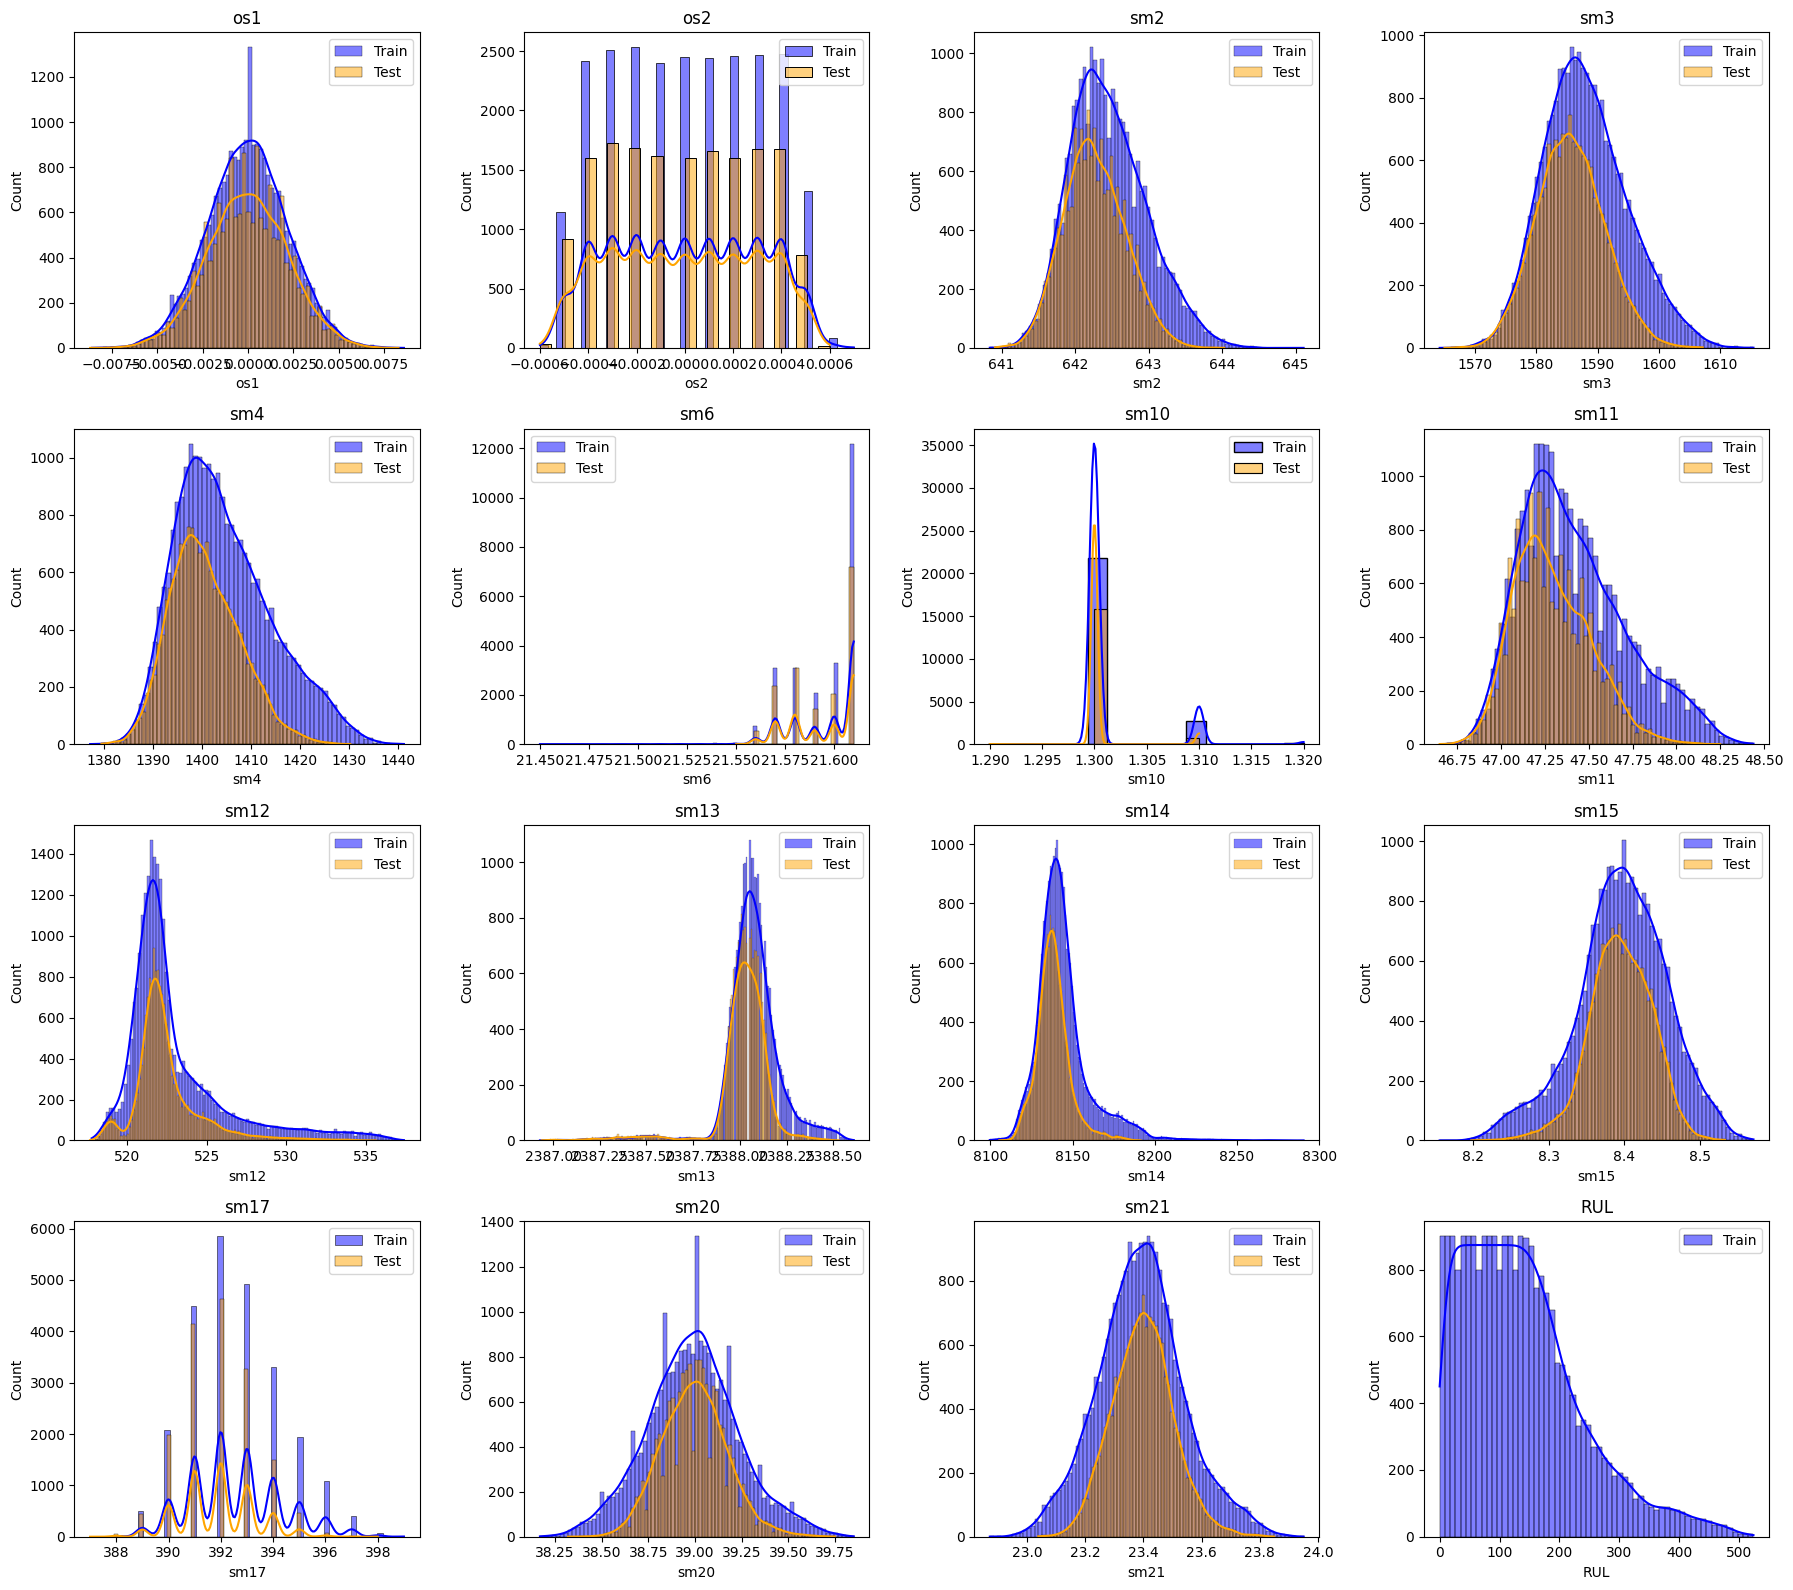

In [ ]:
# Calculate the number of rows needed
columns = train_data.drop(['unitnr', 'cycle'], axis=1).columns
num_rows = len(columns) // 4
if len(columns) % 4 != 0:
    num_rows += 1

fig, axes = plt.subplots(num_rows, 4, figsize=(18, 4 * num_rows))
axes = axes.flatten()

# Plot histograms for each sensor
for i, feature in enumerate(columns):
    ax = axes[i]
    sns.histplot(train_data[feature], kde=True, color='blue', label='Train', ax=ax)
    if feature != 'RUL':
        sns.histplot(test_data[feature], kde=True, color='orange', label='Test', ax=ax)
    ax.set_title(feature)
    ax.legend()

# Hide empty subplots
for i in range(len(columns), num_rows * 4):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## Boxplots

We can see some extreme values, that only occur in the Train dataset and not in the test dataset

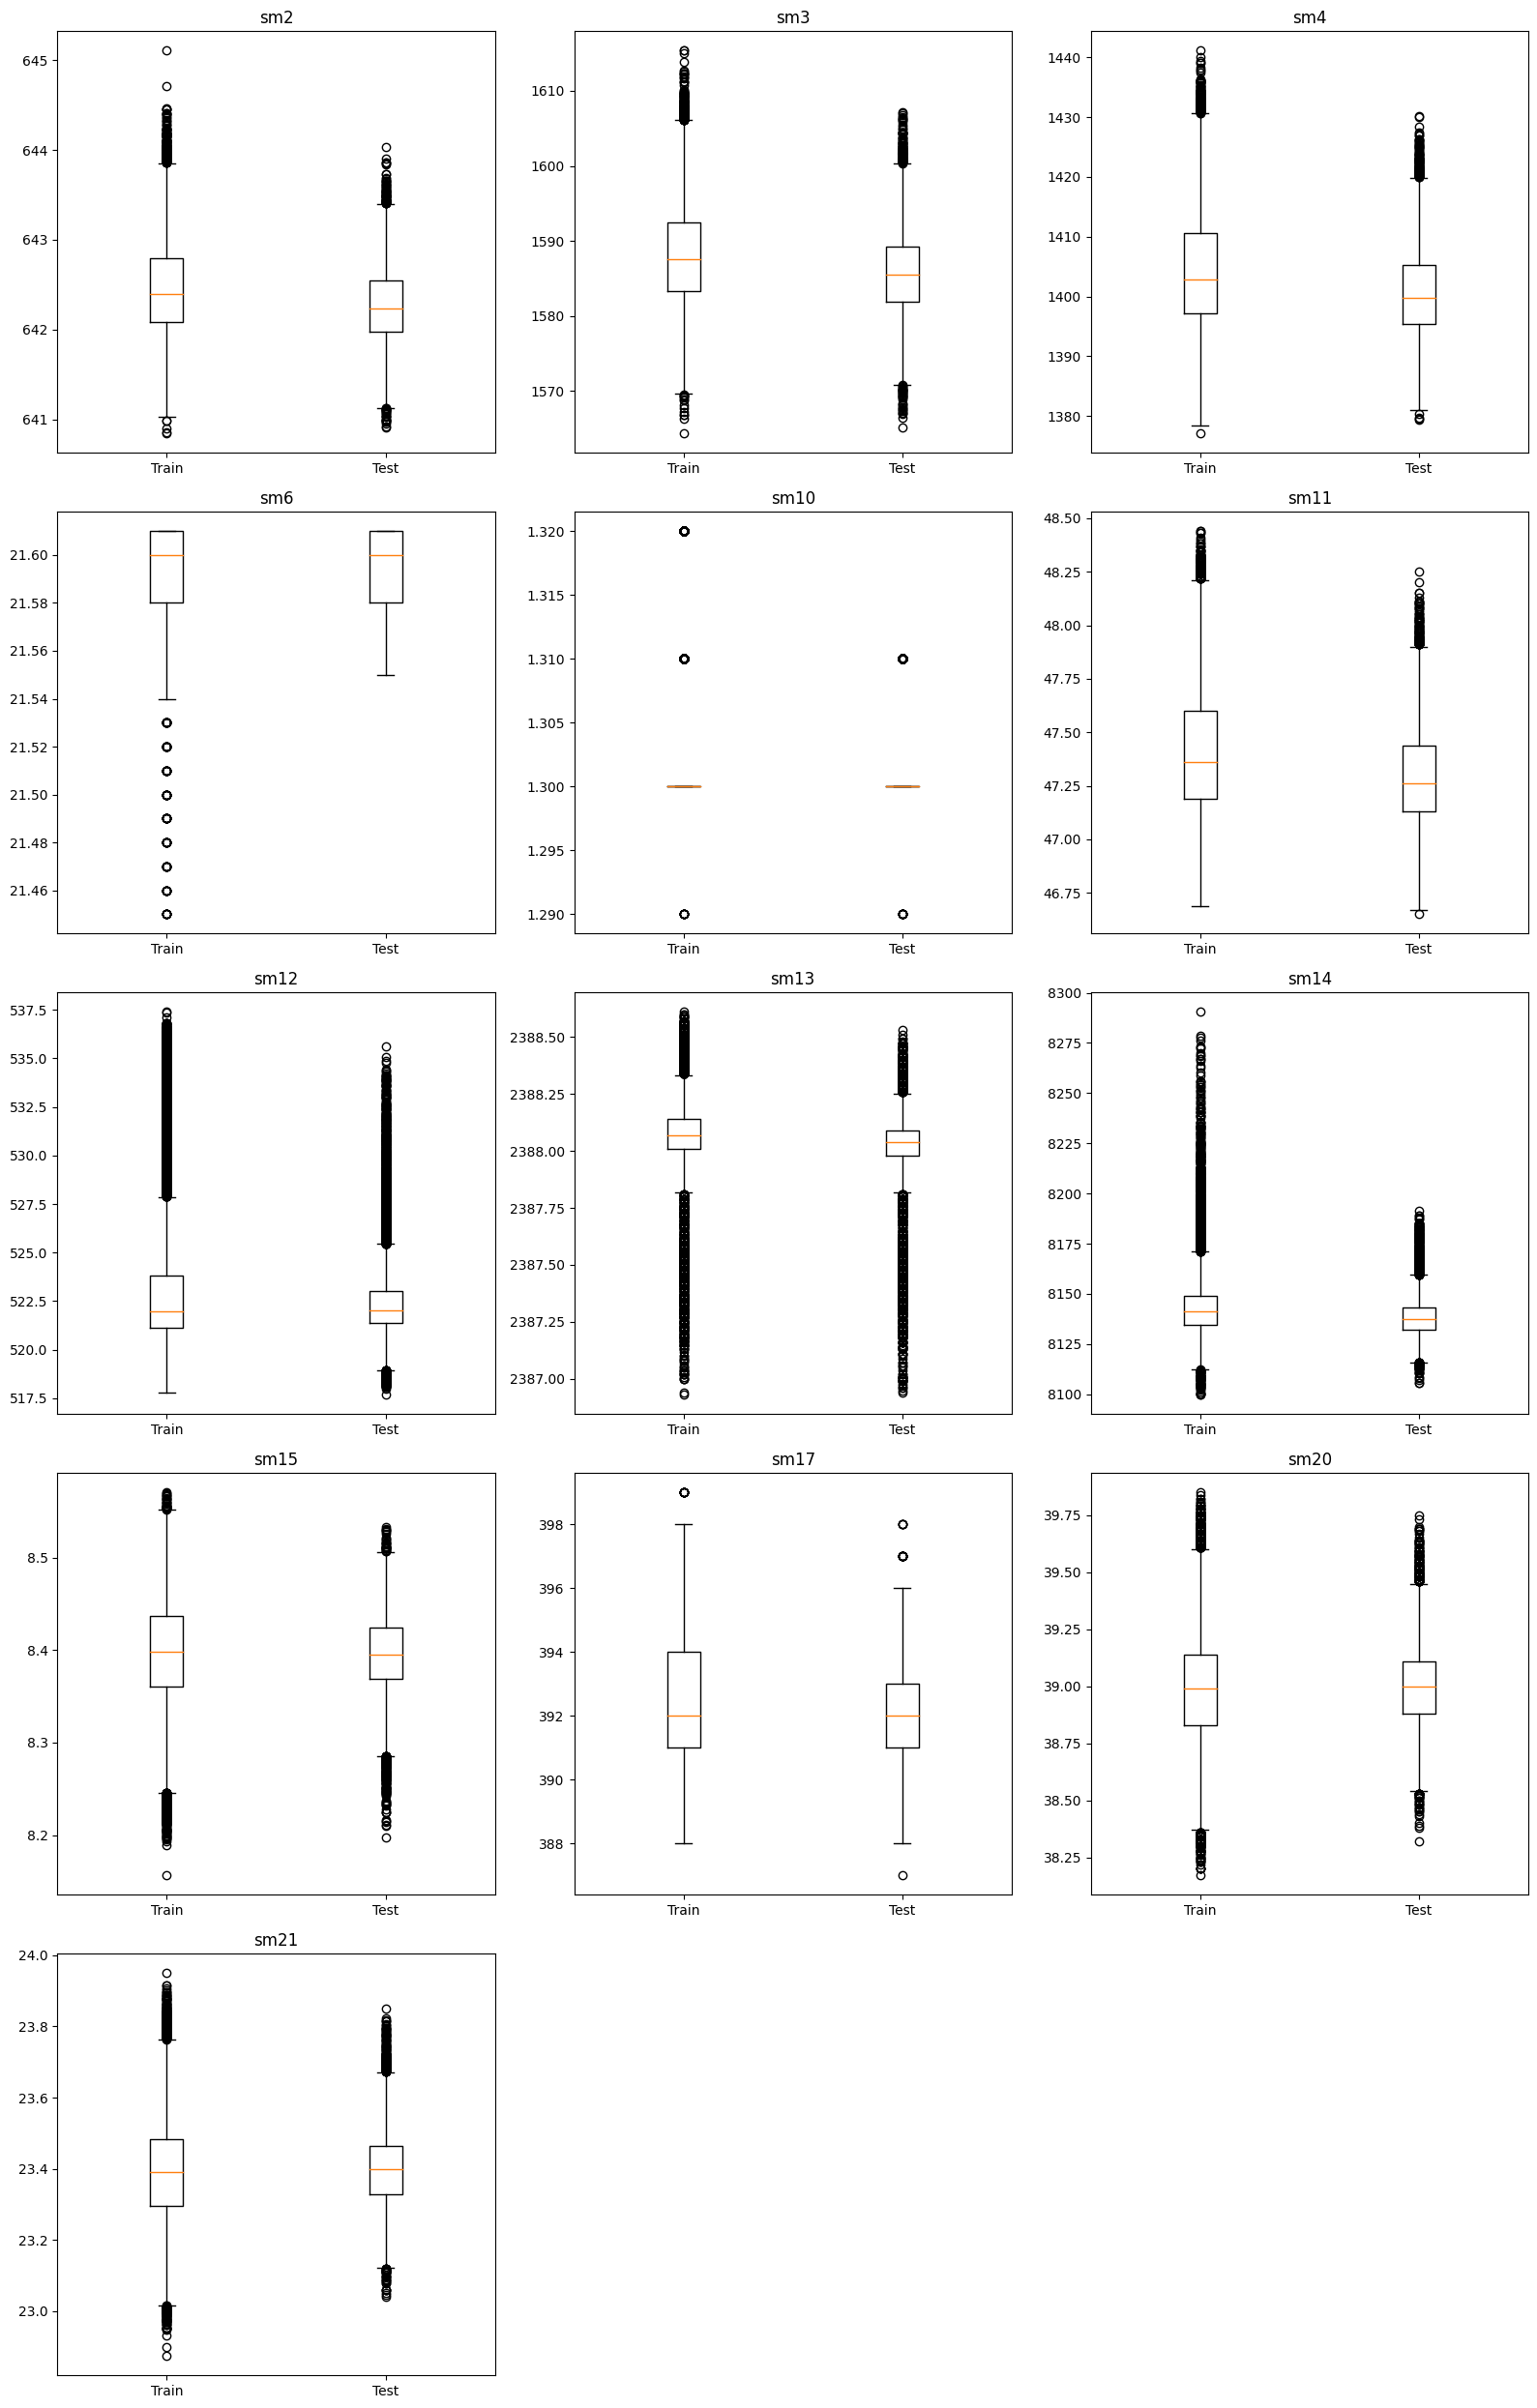

In [ ]:
# Calculate the number of rows needed
sensor_columns = [col for col in train_data.columns if col.startswith('sm')]
num_rows = len(sensor_columns) // 3
if len(sensor_columns) % 3 != 0:
    num_rows += 1

fig, axes = plt.subplots(num_rows, 3, figsize=(16, 5 * num_rows))
axes = axes.flatten()

# Plot each sensor's boxplot for both train and test datasets
for i, sensor in enumerate(sensor_columns):
    ax = axes[i]
    ax.boxplot([train_data[sensor], test_data[sensor]], labels=['Train', 'Test'])
    ax.set_title(sensor)
    ax.set_xticklabels(['Train', 'Test'])

# Hide empty subplots
for i in range(len(sensor_columns), num_rows * 3):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Training





In [ ]:
def train (dataset, RUL):
  # Modellinitialisierung
  model = lgb.LGBMRegressor(random_state=12)
  # Model-Training
  model.fit(dataset, RUL)

  prediction = model.predict(dataset)
  plt.figure(figsize=(12,5))
  plt.plot((prediction[:2000]), label="Prediction")
  plt.plot((RUL[:2000]), label="Reale RUL")
  plt.legend()
  plt.show()

  rms = sqrt(mean_squared_error(RUL.values.reshape(-1), prediction))
  print("The RMSE auf Trainingsdaten ist :", rms)
  return model

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001841 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2713
[LightGBM] [Info] Number of data points in the train set: 24720, number of used features: 16
[LightGBM] [Info] Start training from score 138.077063


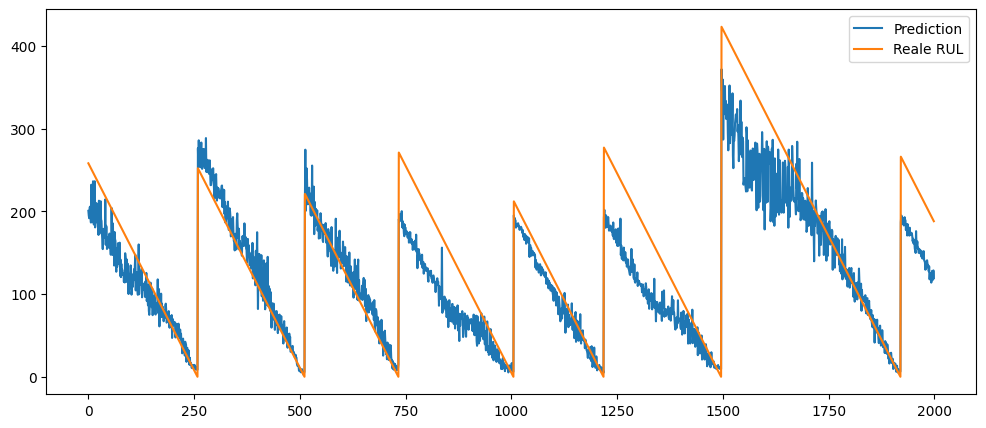

The RMSE auf Trainingsdaten ist : 43.093565599413445


In [ ]:
X = train_data.drop(columns = ["RUL", "unitnr"])
Y = train_data["RUL"]
model = train(X, Y)

In [ ]:
test1 = test_data.drop(columns = (all_columns_to_drop + list(high_corr)))

idx = test1.groupby('unitnr')['cycle'].idxmax()
max_cycle_df = test1.loc[idx]

max_cycle_df.drop(columns = ["unitnr"], inplace = True)


prediction = model.predict(max_cycle_df)
prediction = np.round(prediction)

rms = sqrt(mean_squared_error(rul_data, prediction))
print("The RMSE auf Testdaten ist :", rms)

The RMSE auf Testdaten ist : 37.196639633171166


## Try moving average

Performs better on Train data but worse on test data. Why ? How

In [ ]:
def calculate_moving_averages(data, sensor_columns, window_size=5, unit_column='unitnr', cycle_column='cycle'):
    """
    Calculate moving averages for sensor data within each unit and ensure the output matches the input length.

    Parameters:
        data (DataFrame): The input DataFrame containing the data.
        sensor_columns (list): List of columns to apply the moving average.
        window_size (int): The number of cycles over which to calculate the moving average.
        unit_column (str): Column name representing the unit identifier.
        cycle_column (str): Column name representing the cycle.

    Returns:
        DataFrame: A DataFrame with moving averages computed, along with unit and cycle columns.
    """
    # Initialize an empty DataFrame to hold the moving averages
    moving_avg_data = pd.DataFrame()

    # Loop over each unit in the data
    for unit in data[unit_column].unique():
        # Filter data for the current unit
        unit_data = data[data[unit_column] == unit]

        # Apply rolling window moving average
        ma_unit_data = unit_data[sensor_columns].rolling(window=window_size, min_periods=1).mean()

        # Since rolling operation may create NaN, use forward fill to handle initial NaN values
        ma_unit_data.fillna(method='ffill', inplace=True)
        ma_unit_data.fillna(method='bfill', inplace=True)  # Ensure all NaNs are filled

        # Include non-sensor columns that should remain unchanged
        non_sensor_data = unit_data[[unit_column, cycle_column]]

        # Concatenate the non-sensor data with the calculated moving averages
        result_unit_data = pd.concat([non_sensor_data, ma_unit_data], axis=1)

        # Append the processed data of the current unit to the overall DataFrame
        moving_avg_data = pd.concat([moving_avg_data, result_unit_data])

    return moving_avg_data

In [ ]:
# Define your sensor columns, assume columns start with 'sm'
sensor_columns = [col for col in train_data.columns if col.startswith('sm')]

# Call the function with the DataFrame and sensor columns
moving_average_data = calculate_moving_averages(train_data, sensor_columns, window_size=10)

Zeitliche Verlauf von Turbofan mit id 66. X Axis is the Cycle Number, Y Axis is the Sensor Value


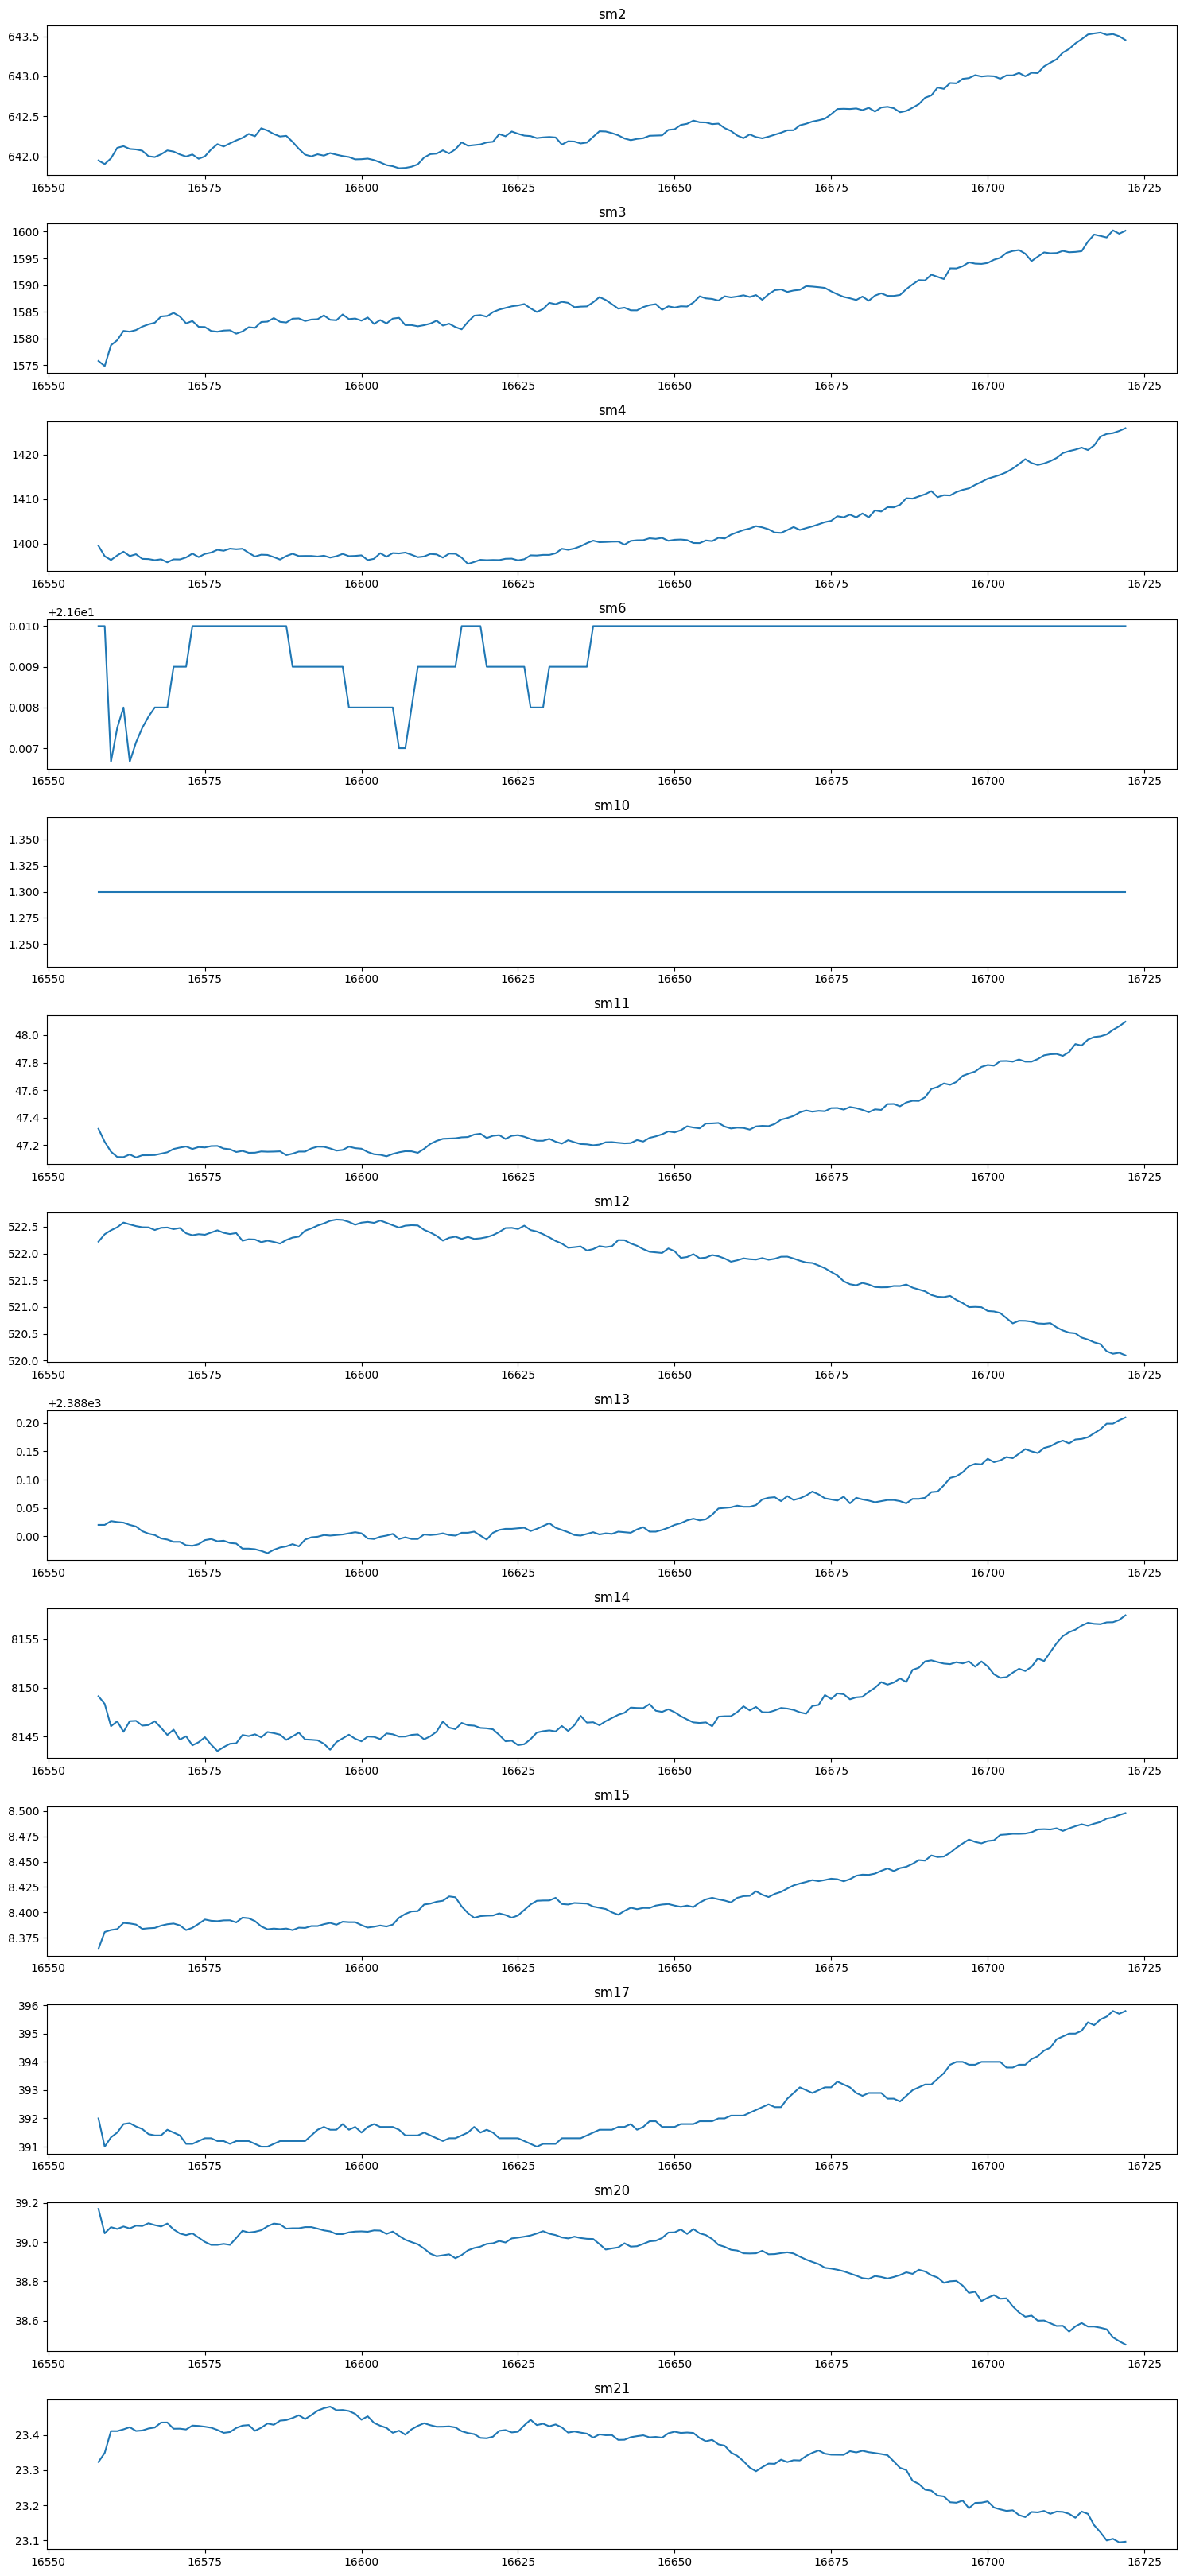

In [ ]:
print_time_series(dataframe = moving_average_data, id=66)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003737 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3102
[LightGBM] [Info] Number of data points in the train set: 24720, number of used features: 14
[LightGBM] [Info] Start training from score 138.077063


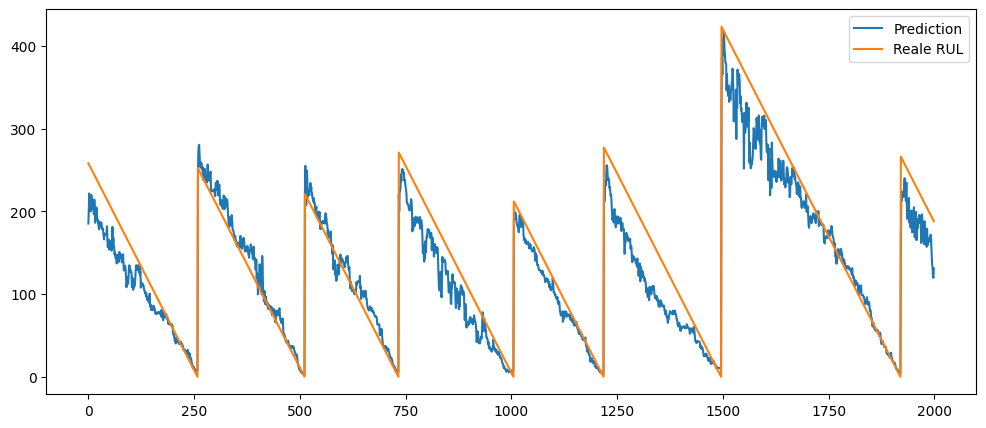

The RMSE auf Trainingsdaten ist : 27.593600788565332


In [ ]:
X = moving_average_data.drop(columns = [ "unitnr"])
Y = train_data["RUL"]
model = train(X, Y)

In [ ]:
test1 = test_data.drop(columns = (all_columns_to_drop + list(high_corr)))

moving_average_test = calculate_moving_averages(test_data, sensor_columns, window_size =10)

idx = moving_average_test.groupby('unitnr')['cycle'].idxmax()
max_cycle_df = moving_average_test.loc[idx]

max_cycle_df.drop(columns = ["unitnr"], inplace = True)


prediction = model.predict(max_cycle_df)
prediction = np.round(prediction)

rms = sqrt(mean_squared_error(rul_data, prediction))
print("The RMSE auf Testdaten ist :", rms)

The RMSE auf Testdaten ist : 43.66337137693332


In [ ]:
max_cycle_df

cycle      sm2       sm3       sm4     sm6   sm10    sm11     sm12      sm13      sm14  \
232      233  642.709  1588.294  1405.536  21.581  1.310  47.543  527.796  2388.175  8158.606   
356      124  642.830  1590.869  1413.097  21.610  1.300  47.662  520.828  2388.167  8125.173   
590      234  642.690  1593.862  1412.901  21.600  1.310  47.705  530.902  2388.316  8169.243   
658       68  642.555  1587.126  1407.228  21.610  1.300  47.495  521.470  2388.096  8131.369   
796      138  641.987  1583.340  1393.864  21.575  1.300  47.153  521.413  2387.939  8135.012   
...      ...      ...       ...       ...     ...    ...     ...      ...       ...       ...   
15782    358  642.543  1592.126  1407.232  21.598  1.309  47.530  527.997  2388.186  8156.966   
15877     95  642.038  1586.135  1396.318  21.609  1.300  47.193  522.345  2388.010  8140.504   
16059    182  643.227  1594.772  1422.168  21.610  1.300  47.880  520.551  2388.127  8179.465   
16348    289  643.022  1596.755  1419.580  21.587  1.310  48.005  533.192  2388.391  8180.774   
16595    247  642.663  1592.186  1411.107  21.579  1.310  47.630  528.888  2388.250  8164.104   

          sm15   sm17    sm20      sm21  
232    8.30867  393.7  39.304  23.57852  
356    8.44414  393.7  38.762  23.27513  
590    8.29506  394.7  39.385  23.65698  
658    8.43770  393.2  38.790  23.34224  
796    8.39786  390.7  38.950  23.44944  
...        ...    ...     ...       ...  
15782  8.33073  392.4  39.294  23.58315  
15877  8.39166  391.9  38.936  23.43747  
16059  8.48910  395.7  38.607  23.12908  
16348  8.25769  395.0  39.556  23.68038  
16595  8.30787  394.2  39.366  23.58321  

[100 rows x 14 columns]

## Try exponential smoothing average

In [ ]:
def calculate_exponential_smoothing(data, sensor_columns, span=5, unit_column='unitnr', cycle_column='cycle'):
    """
    Calculate exponential smoothing for sensor data within each unit.

    Parameters:
        data (DataFrame): The input DataFrame containing the data.
        sensor_columns (list): List of columns to apply the exponential smoothing.
        span (int): Specifies the span for the smoothing (similar to window size but provides smoothing factor).
        unit_column (str): Column name representing the unit identifier.
        cycle_column (str): Column name representing the cycle.

    Returns:
        DataFrame: A DataFrame with exponential smoothing computed, along with unit and cycle columns.
    """
    # Initialize an empty DataFrame to hold the smoothed data
    smoothed_data = pd.DataFrame()

    # Loop over each unit in the data
    for unit in data[unit_column].unique():
        # Filter data for the current unit
        unit_data = data[data[unit_column] == unit]

        # Apply exponential weighted function for smoothing
        es_unit_data = unit_data[sensor_columns].ewm(span=span, adjust=False).mean()

        # Include non-sensor columns that should remain unchanged
        non_sensor_data = unit_data[[unit_column, cycle_column]]

        # Concatenate the non-sensor data with the calculated smoothed data
        result_unit_data = pd.concat([non_sensor_data, es_unit_data], axis=1)

        # Append the processed data of the current unit to the overall DataFrame
        smoothed_data = pd.concat([smoothed_data, result_unit_data])

    return smoothed_data

In [ ]:
# Define your sensor columns, assume columns start with 'sm'
sensor_columns = [col for col in train_data.columns if col.startswith('sm')]

# Call the function with the DataFrame and sensor columns
smoothened_data = calculate_exponential_smoothing(train_data, sensor_columns)

Zeitliche Verlauf von Turbofan mit id 11. X Axis is the Cycle Number, Y Axis is the Sensor Value


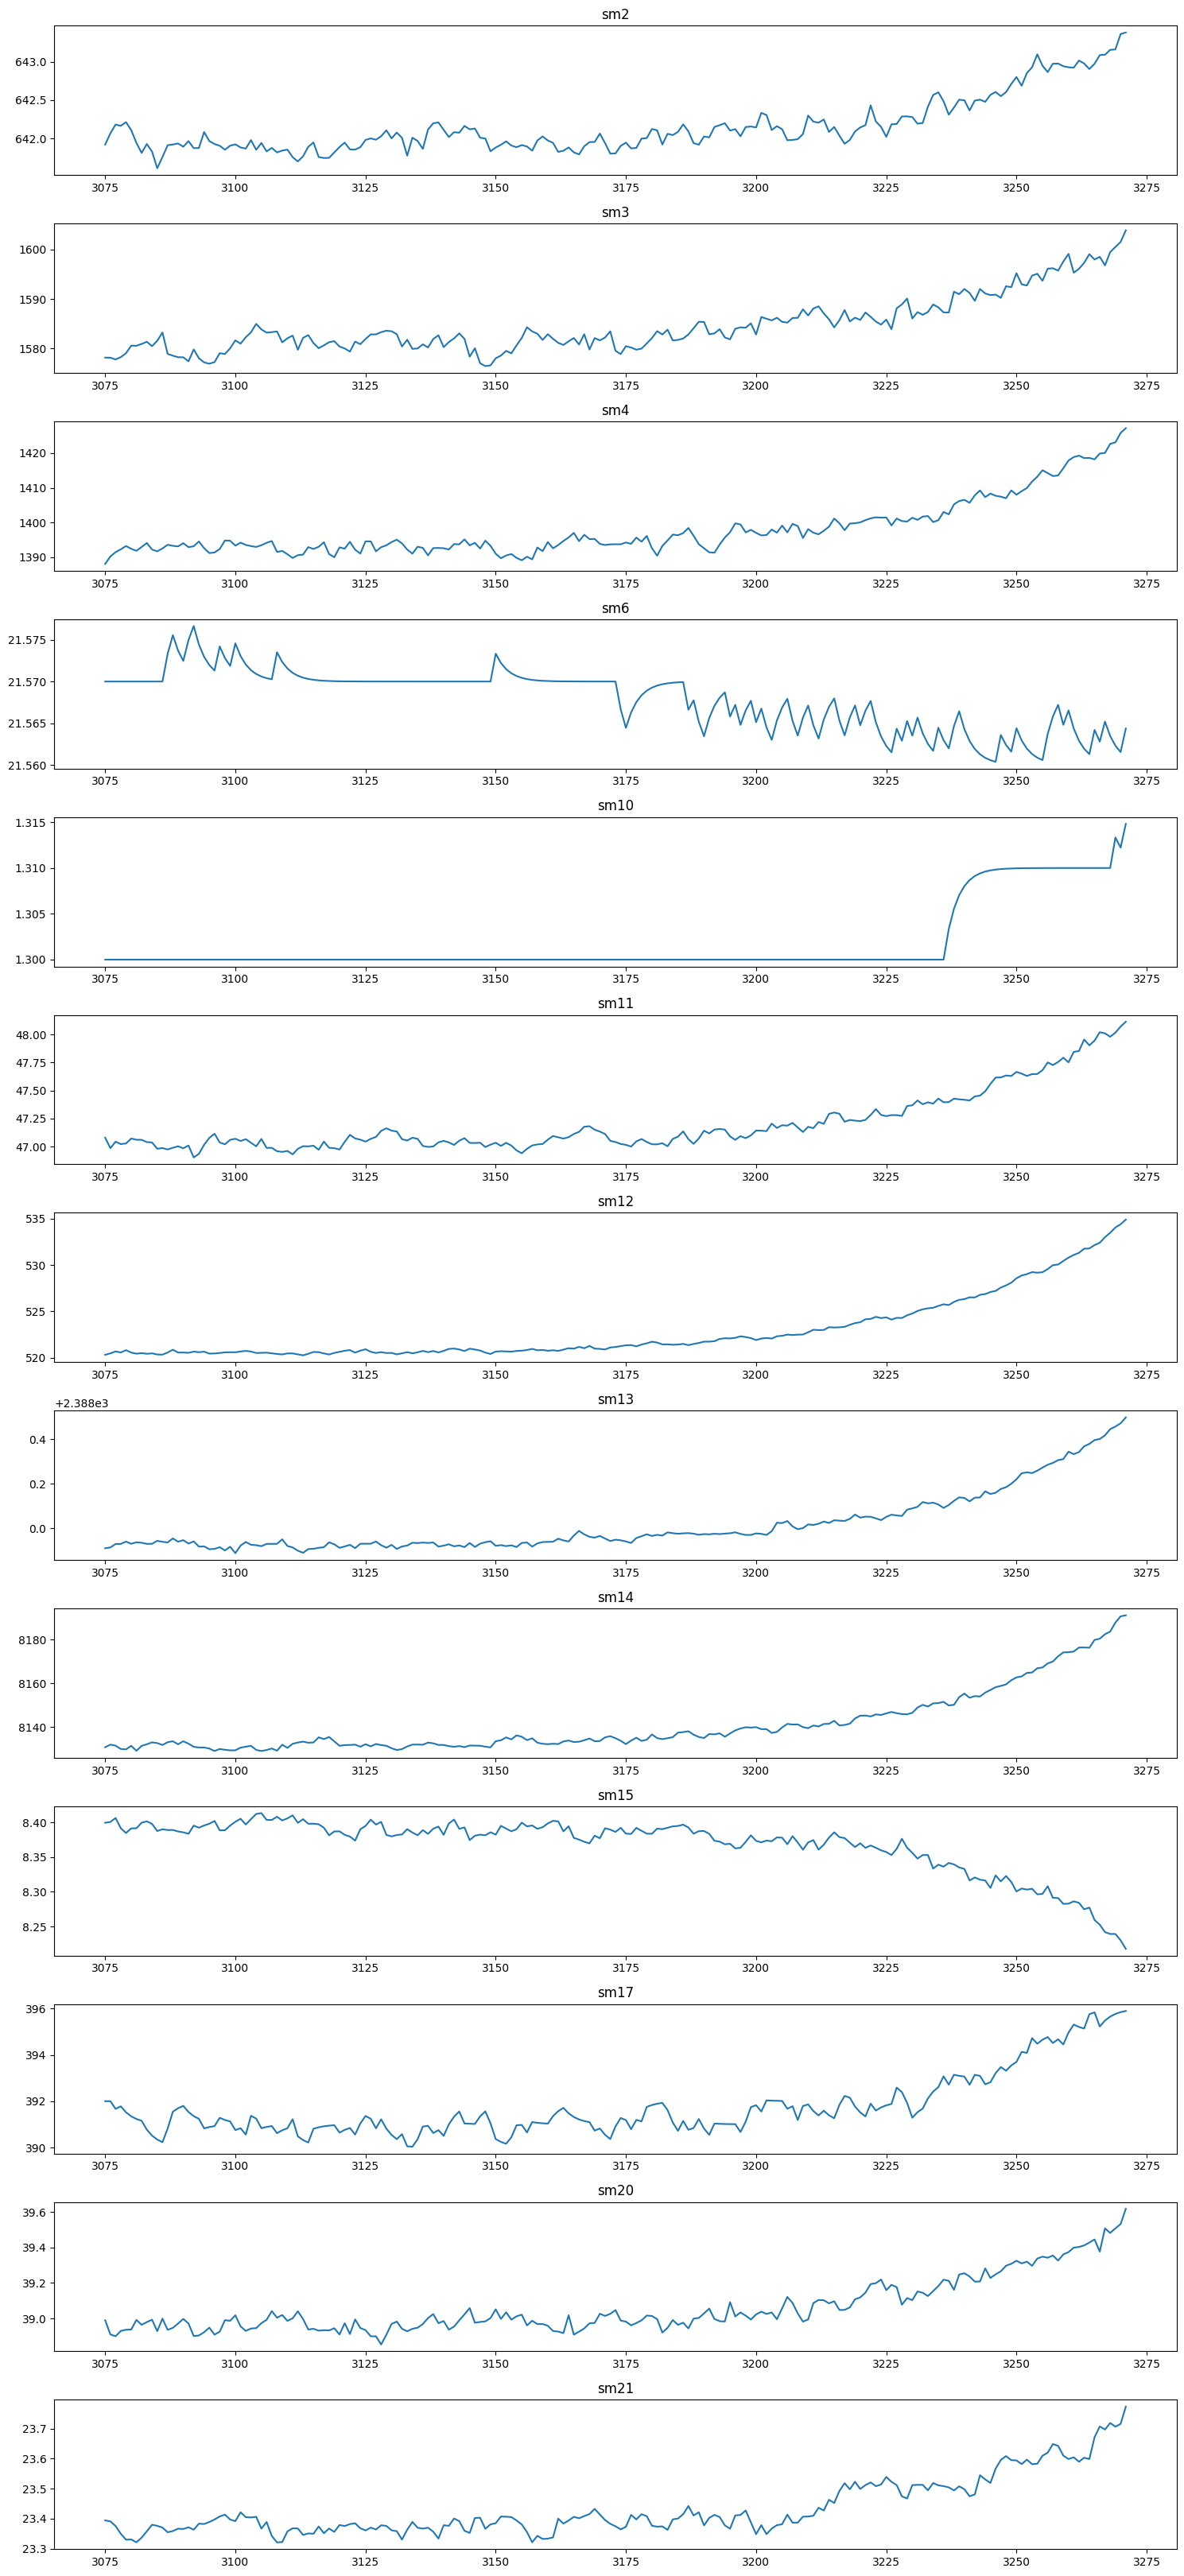

In [ ]:
print_time_series(dataframe = smoothened_data , id=11)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005678 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 24720, number of used features: 14
[LightGBM] [Info] Start training from score 138.077063


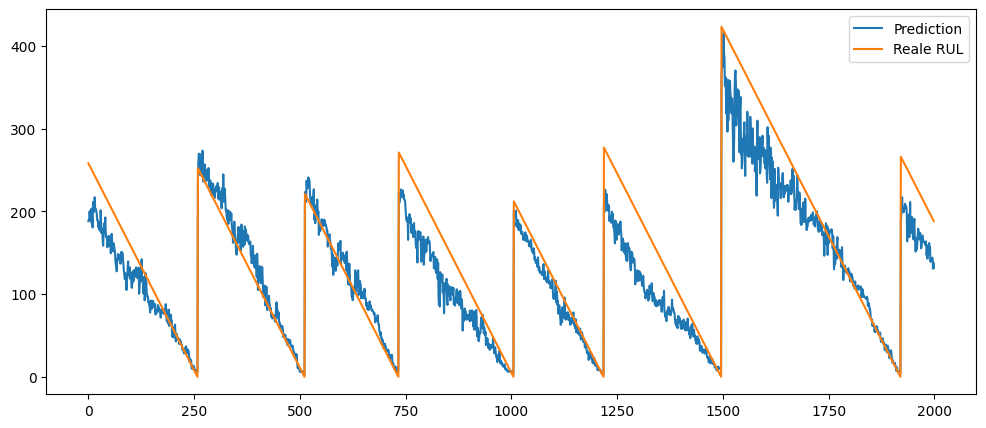

The RMSE auf Trainingsdaten ist : 31.32185158285672


In [ ]:
X = smoothened_data.drop(columns = [ "unitnr"])
Y = train_data["RUL"]
model = train(X, Y)

In [ ]:
test1 = test_data.drop(columns = (all_columns_to_drop + list(high_corr)))

smoothened_test = calculate_exponential_smoothing(test_data, sensor_columns)

idx = smoothened_test.groupby('unitnr')['cycle'].idxmax()
max_cycle_df = smoothened_test.loc[idx]

max_cycle_df.drop(columns = ["unitnr"], inplace = True)


prediction = model.predict(max_cycle_df)
prediction = np.round(prediction)

rms = sqrt(mean_squared_error(rul_data, prediction))
print("The RMSE auf Testdaten ist :", rms)

The RMSE auf Testdaten ist : 38.81868106981483


## Observe especially data before Breakdown

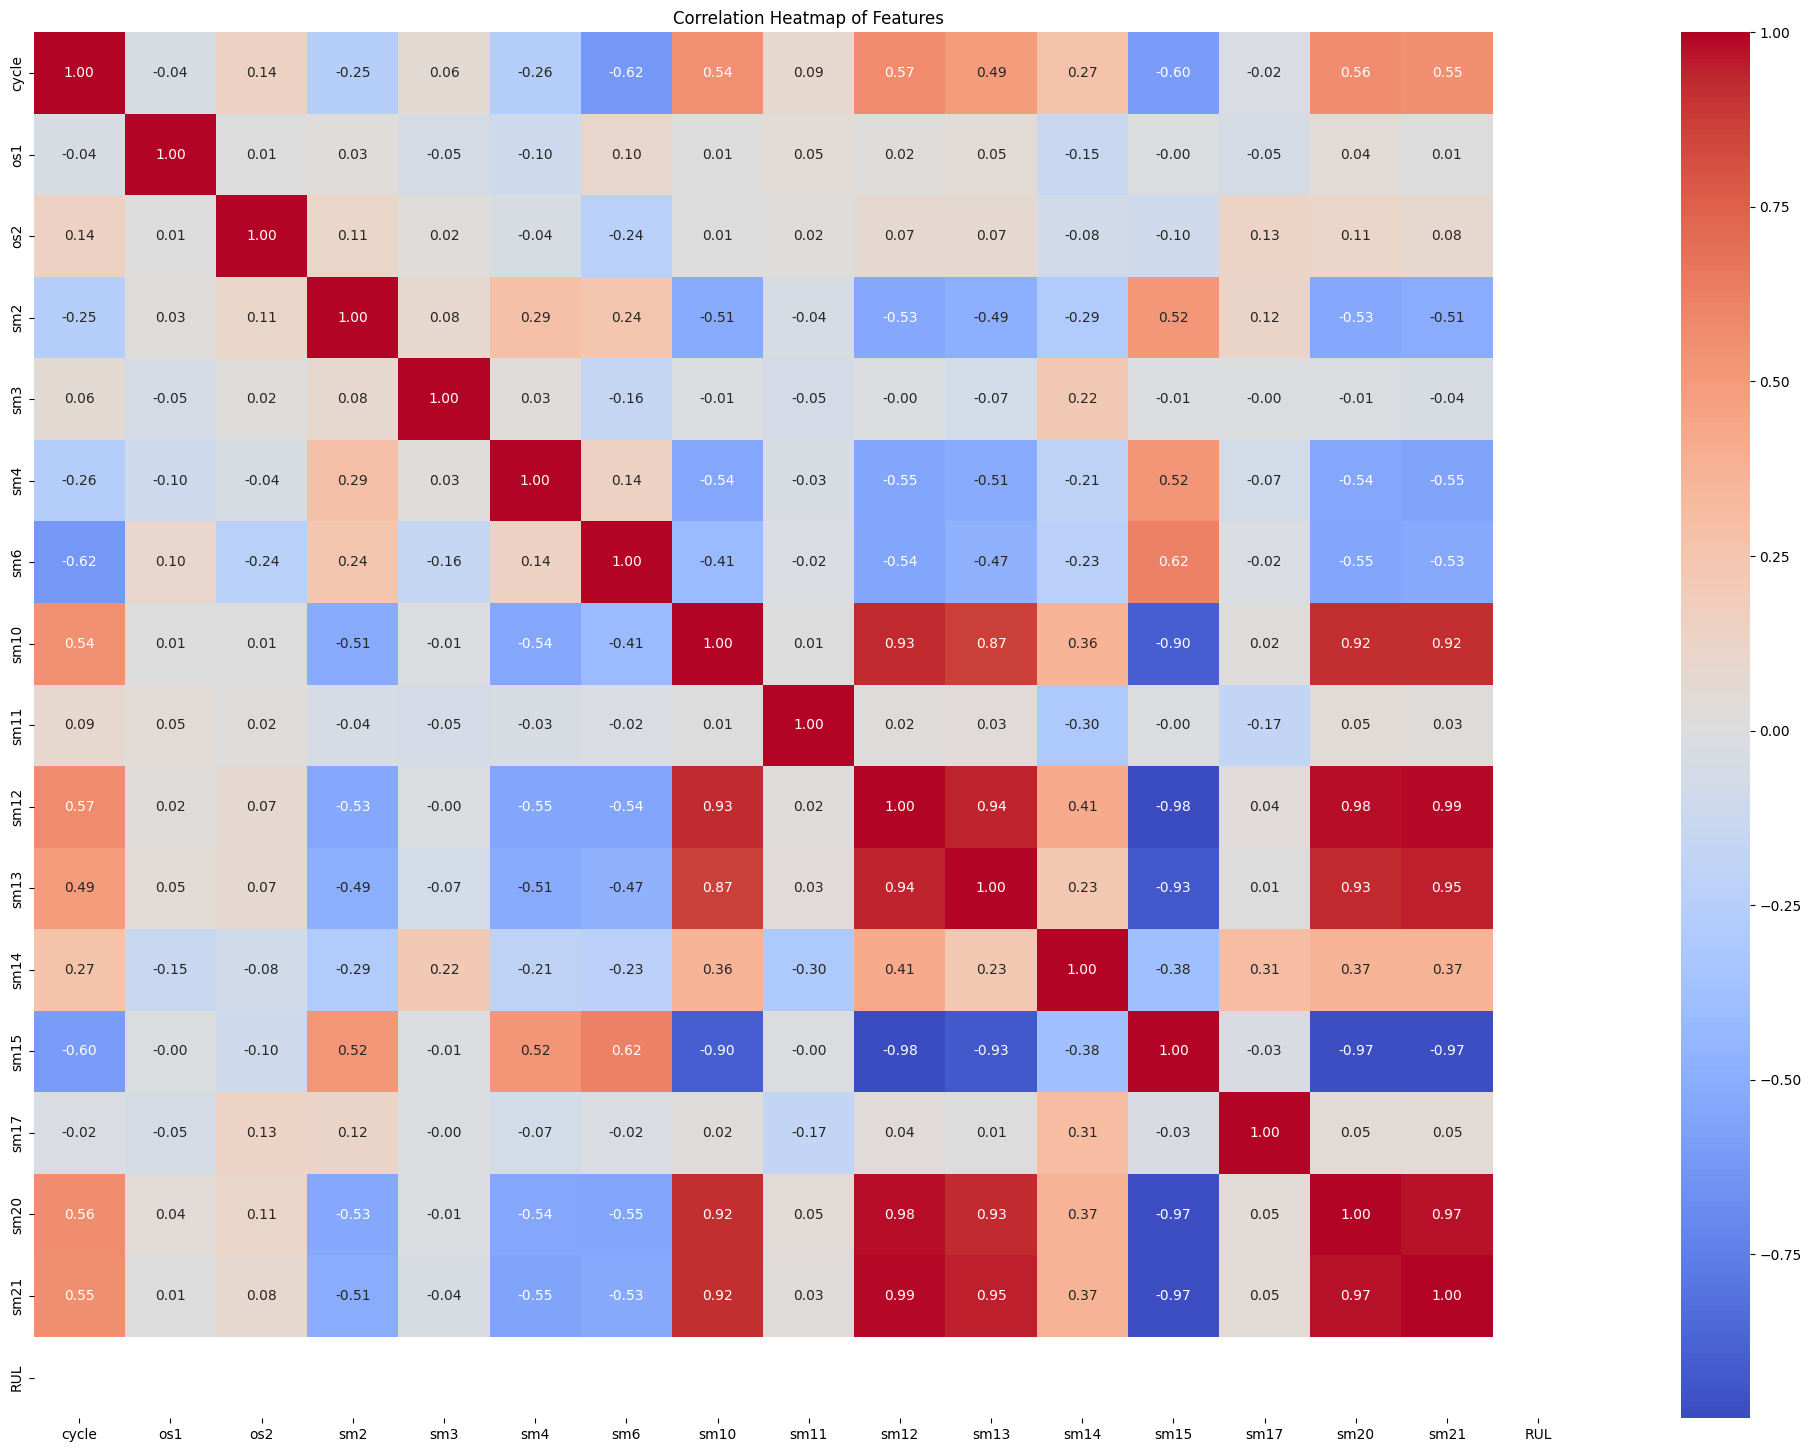

In [ ]:
# Filter the DataFrame to only include rows where 'RUL' is equal to 0
filtered_data = train_data[train_data['RUL'] == 1]

# Drop the 'unitnr' column and compute the correlation matrix for the filtered data
corr_matrix = filtered_data.drop('unitnr', axis=1).corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(25, 18))  # Adjust the size of the figure as needed
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap of Features')
plt.show()

Zeitliche Verlauf von Turbofan mit id 86. X Axis is the Cycle Number, Y Axis is the Sensor Value


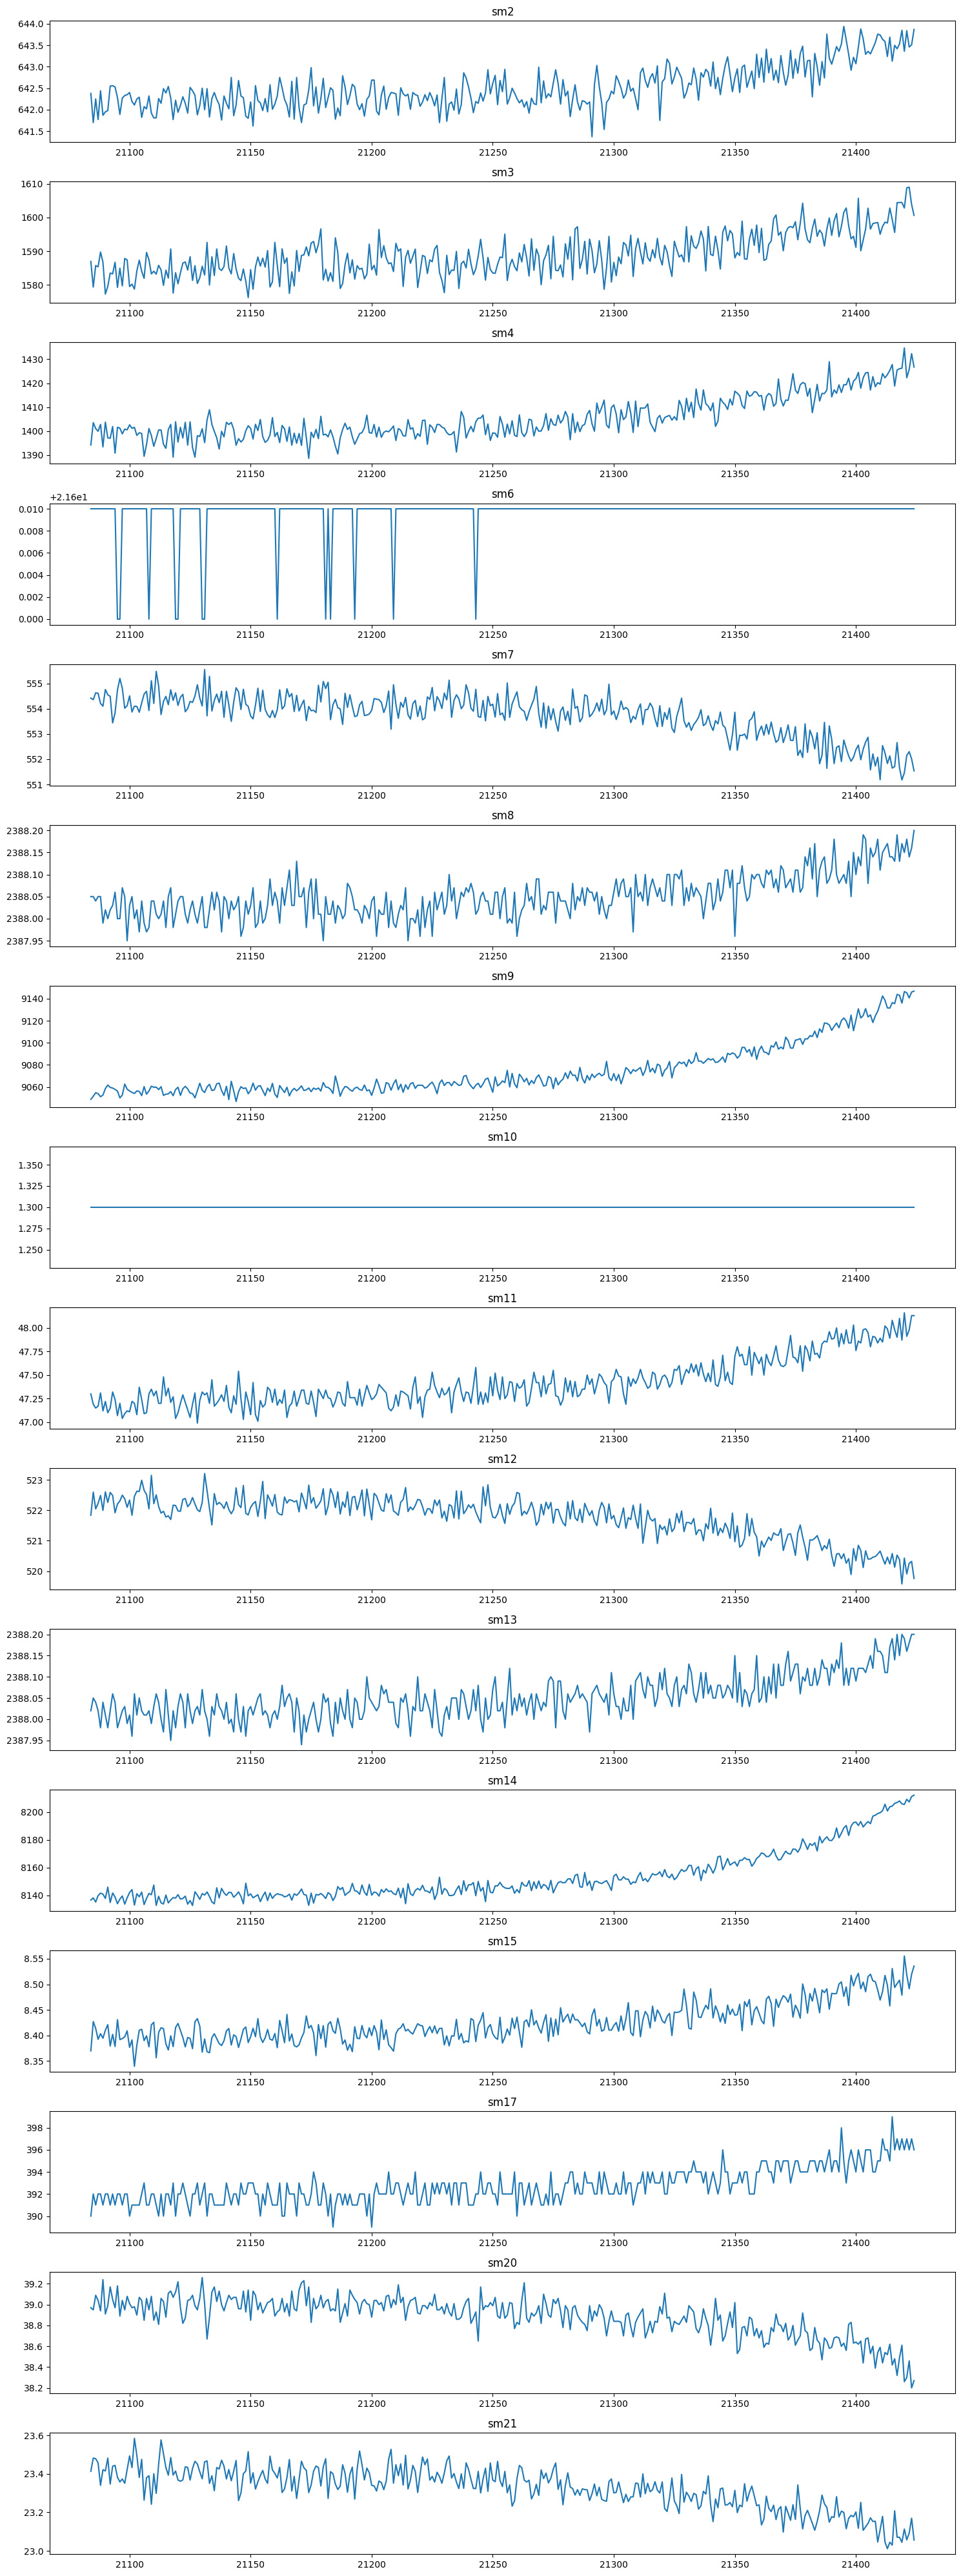

In [ ]:
print_time_series(id=86)